In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.cluster.hierarchy as sch
import datetime

In [2]:
from sklearn.cluster import KMeans

# center and scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [4]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [5]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64') |(x.dtypes == 'int32') | (x.dtypes == 'float32'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

# Import Data

In [7]:
dis = pd.read_csv("Datasets/Discount_Coupon.csv")
markt = pd.read_csv("Datasets/Marketing_Spend.csv")
online_sales = pd.read_csv("Datasets/Online_Sales.csv")
custmer = pd.read_excel("Datasets/CustomersData.xlsx")
tax = pd.read_excel("Datasets/Tax_amount.xlsx")

In [8]:
custmer.CustomerID.nunique()

1468

# Merge datasets

In [9]:
online_sales_custmer =pd.merge(online_sales, custmer, on = "CustomerID", how = "left")
o_c_t =pd.merge(online_sales_custmer, tax, on = "Product_Category", how="left")
#o_c_t.info()

In [10]:
o_c_t.Transaction_Date = pd.to_datetime(o_c_t.Transaction_Date, format = "%Y%m%d")
o_c_t['tx_month'] = o_c_t.Transaction_Date.dt.strftime("%b")

In [11]:
# Now adding discount dataframe with the o_c_t 
df =pd.merge(o_c_t, dis, left_on= ['tx_month', 'Product_Category'], right_on = ['Month', 'Product_Category'], how = "inner")

In [12]:
df.drop("tx_month", axis= 1, inplace=True)
#df.head()


In [13]:
markt.head()

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


In [14]:
df.shape

(52524, 17)

### let's see what the data looks like
### Basic Exploratory Data Analysis

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52524 entries, 0 to 52523
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52524 non-null  int64         
 1   Transaction_ID       52524 non-null  int64         
 2   Transaction_Date     52524 non-null  datetime64[ns]
 3   Product_SKU          52524 non-null  object        
 4   Product_Description  52524 non-null  object        
 5   Product_Category     52524 non-null  object        
 6   Quantity             52524 non-null  int64         
 7   Avg_Price            52524 non-null  float64       
 8   Delivery_Charges     52524 non-null  float64       
 9   Coupon_Status        52524 non-null  object        
 10  Gender               52524 non-null  object        
 11  Location             52524 non-null  object        
 12  Tenure_Months        52524 non-null  int64         
 13  GST                  52524 non-

In [16]:
df.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months', 'GST', 'Month', 'Coupon_Code', 'Discount_pct'],
      dtype='object')

In [17]:
df.shape

(52524, 17)

In [18]:
df.describe()

,CustomerID,Transaction_ID,Transaction_Date,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct
count,52524.000000,52524.000000,52524,52524.000000,52524.000000,52524.000000,52524.000000,52524.000000,52524.000000
mean,15345.347213,32445.093367,2019-07-06 05:10:50.582591232,4.500171,52.429089,10.476922,26.140393,0.137433,19.953164
min,12346.000000,16679.000000,2019-01-01 00:00:00,1.000000,0.390000,0.000000,2.000000,0.050000,10.000000
25%,13869.000000,25404.000000,2019-04-12 00:00:00,1.000000,5.700000,6.000000,15.000000,0.100000,10.000000
50%,15311.000000,32678.000000,2019-07-14 00:00:00,1.000000,16.990000,6.000000,27.000000,0.180000,20.000000
75%,16996.000000,39174.250000,2019-09-27 00:00:00,2.000000,119.000000,6.500000,37.000000,0.180000,30.000000
max,18283.000000,48497.000000,2019-12-31 00:00:00,900.000000,355.740000,521.360000,50.000000,0.180000,30.000000
std,1766.862675,8654.724704,NaN,20.159985,64.156649,19.343153,13.473500,0.045865,8.127280


In [19]:
df.isna().sum()

CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
Gender                 0
Location               0
Tenure_Months          0
GST                    0
Month                  0
Coupon_Code            0
Discount_pct           0
dtype: int64

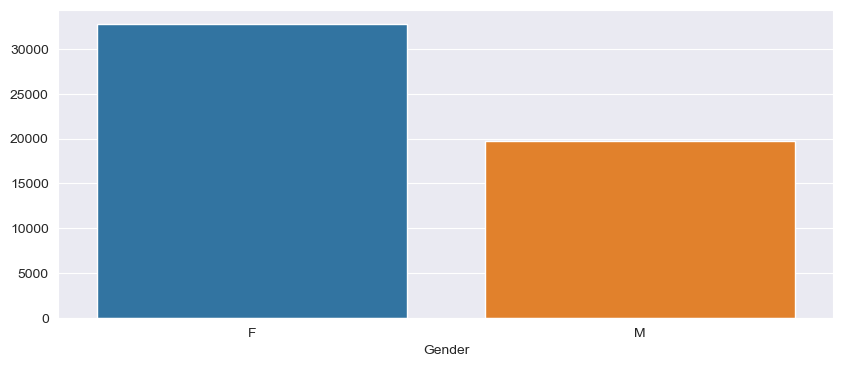

In [20]:
# Distribution of gender male and female
genders = df.Gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=genders.index, y=genders.values)
plt.show()

In [21]:
# Checking duplicate values in the dataframe
df.duplicated().sum()

0

In [22]:
df.dtypes

CustomerID                      int64
Transaction_ID                  int64
Transaction_Date       datetime64[ns]
Product_SKU                    object
Product_Description            object
Product_Category               object
Quantity                        int64
Avg_Price                     float64
Delivery_Charges              float64
Coupon_Status                  object
Gender                         object
Location                       object
Tenure_Months                   int64
GST                           float64
Month                          object
Coupon_Code                    object
Discount_pct                    int64
dtype: object

In [23]:
df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10
2,13047,16684,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Clicked,M,California,43,0.1,Jan,ELEC10,10
3,13047,16684,2019-01-01,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,1,81.50,6.5,Used,M,California,43,0.1,Jan,ELEC10,10
4,13047,16688,2019-01-01,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,122.77,6.5,Used,M,California,43,0.1,Jan,ELEC10,10


In [24]:
#define categorical list 
for x in ['Product_Category','Product_Description', 'Product_SKU','Coupon_Status',"Gender" ,"Coupon_Code"]:
    df[x]=df[x].astype('object')

In [25]:
# Separate numerical and categorical variable
# Find numerical variable in Data frame.
# This will return a list
numeric_var_names = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']]

#Print the data frame
print( numeric_var_names)
print(cat_var_names)

['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price', 'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct']
['Product_SKU', 'Product_Description', 'Product_Category', 'Coupon_Status', 'Gender', 'Location', 'Month', 'Coupon_Code']


In [26]:
#Convert a list in to dataframe 
#Information about numericvariable in custdata_df
df_num=df[numeric_var_names]
df_num

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct
0,17850,16679,1,153.71,6.5,12,0.10,10
1,17850,16680,1,153.71,6.5,12,0.10,10
2,13047,16684,2,122.77,6.5,43,0.10,10
3,13047,16684,1,81.50,6.5,43,0.10,10
4,13047,16688,1,122.77,6.5,43,0.10,10
...,...,...,...,...,...,...,...,...
52519,14044,47224,1,101.93,0.0,49,0.05,30
52520,15311,47511,2,25.48,0.0,40,0.05,30
52521,12842,47997,1,254.82,0.0,27,0.05,30
52522,14462,48062,1,25.48,0.0,42,0.05,30


In [27]:
#Convert a list in to dataframe 
#Information about categorical variable in custdata_df
df_cat=df[cat_var_names]
df_cat.head(5)

,Product_SKU,Product_Description,Product_Category,Coupon_Status,Gender,Location,Month,Coupon_Code
0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,ELEC10
1,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,ELEC10
2,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,Clicked,M,California,Jan,ELEC10
3,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,Used,M,California,Jan,ELEC10
4,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,Used,M,California,Jan,ELEC10


# Missing Value Treatment

In [28]:
df_num = df_num.apply(missing_imputation)
df_num.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CustomerID,52524.0,0.0,8.059990e+08,15345.347213,15311.00,1766.862675,3.121804e+06,12346.00,12413.00,12585.00,12782.00,13869.0,15311.00,16996.00,17799.00,17967.00,18179.00,18283.00
Transaction_ID,52524.0,0.0,1.704146e+09,32445.093367,32678.00,8654.724704,7.490426e+07,16679.00,17057.00,18491.15,20230.30,25404.0,32678.00,39174.25,44703.70,46567.85,48059.54,48497.00
Quantity,52524.0,0.0,2.363670e+05,4.500171,1.00,20.159985,4.064250e+02,1.00,1.00,1.00,1.00,1.0,1.00,2.00,5.00,16.00,60.00,900.00
Avg_Price,52524.0,0.0,2.753785e+06,52.429089,16.99,64.156649,4.116076e+03,0.39,0.99,1.99,2.58,5.7,16.99,119.00,149.00,151.88,279.00,355.74
Delivery_Charges,52524.0,0.0,5.502898e+05,10.476922,6.00,19.343153,3.741576e+02,0.00,6.00,6.00,6.00,6.0,6.00,6.50,14.96,26.43,75.00,521.36
Tenure_Months,52524.0,0.0,1.372998e+06,26.140393,27.00,13.473500,1.815352e+02,2.00,2.00,5.00,7.00,15.0,27.00,37.00,44.00,47.00,50.00,50.00
GST,52524.0,0.0,7.218550e+03,0.137433,0.18,0.045865,2.103621e-03,0.05,0.05,0.05,0.10,0.1,0.18,0.18,0.18,0.18,0.18,0.18
Discount_pct,52524.0,0.0,1.048020e+06,19.953164,20.00,8.127280,6.605268e+01,10.00,10.00,10.00,10.00,10.0,20.00,30.00,30.00,30.00,30.00,30.00


In [29]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52524 entries, 0 to 52523
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        52524 non-null  int64  
 1   Transaction_ID    52524 non-null  int64  
 2   Quantity          52524 non-null  int64  
 3   Avg_Price         52524 non-null  float64
 4   Delivery_Charges  52524 non-null  float64
 5   Tenure_Months     52524 non-null  int64  
 6   GST               52524 non-null  float64
 7   Discount_pct      52524 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 3.2 MB


In [30]:
df_cat = df_cat.apply(missing_imputation)
df_cat.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
Product_SKU,52524,0,GGOENEBJ079499,3511,6.68
Product_Description,52524,0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,3511,6.68
Product_Category,52524,0,Apparel,18126,34.51
Coupon_Status,52524,0,Clicked,26720,50.87
Gender,52524,0,F,32767,62.38
Location,52524,0,Chicago,18240,34.73
Month,52524,0,Aug,6112,11.64
Coupon_Code,52524,0,SALE20,6373,12.13


In [31]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52524 entries, 0 to 52523
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Product_SKU          52524 non-null  object
 1   Product_Description  52524 non-null  object
 2   Product_Category     52524 non-null  object
 3   Coupon_Status        52524 non-null  object
 4   Gender               52524 non-null  object
 5   Location             52524 non-null  object
 6   Month                52524 non-null  object
 7   Coupon_Code          52524 non-null  object
dtypes: object(8)
memory usage: 3.2+ MB


# Again check missing values has been treated or not

In [32]:
# Find the total number of missing values in the numerical data i.e custdata_df_num
print ("\nMissing values in numerical data :  ", df_num.isnull().sum().values.sum())
print ("\nMissing values in categorical data :  ", df_cat.isnull().sum().values.sum())


Missing values in numerical data :   0

Missing values in categorical data :   0


# Dummy creation for categorical data 

In [34]:
df_cat.nunique()

Product_SKU            1135
Product_Description     395
Product_Category         16
Coupon_Status             3
Gender                    2
Location                  5
Month                    12
Coupon_Code              45
dtype: int64

In [35]:
df_cat.isnull().sum()

Product_SKU            0
Product_Description    0
Product_Category       0
Coupon_Status          0
Gender                 0
Location               0
Month                  0
Coupon_Code            0
dtype: int64

In [36]:
# We need to create a function for dummy creation
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [37]:
df_cat=df.select_dtypes(include=['object'])
df_cat


,Product_SKU,Product_Description,Product_Category,Coupon_Status,Gender,Location,Month,Coupon_Code
0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,ELEC10
1,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,Used,M,Chicago,Jan,ELEC10
2,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,Clicked,M,California,Jan,ELEC10
3,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,Used,M,California,Jan,ELEC10
4,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,Used,M,California,Jan,ELEC10
...,...,...,...,...,...,...,...,...
52519,GGOEGGCX056199,Gift Card- $100.00,Gift Cards,Clicked,M,California,Dec,GC30
52520,GGOEGGCX056299,Gift Card - $25.00,Gift Cards,Used,F,Chicago,Dec,GC30
52521,GGOEGGCX056399,Gift Card - $250.00,Gift Cards,Used,F,New Jersey,Dec,GC30
52522,GGOEGGCX056299,Gift Card - $25.00,Gift Cards,Not Used,F,Chicago,Dec,GC30


In [38]:
df_cat2 =df_cat.iloc[ :, [0,1,6,7]]
df_cat2

,Product_SKU,Product_Description,Month,Coupon_Code
0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10
1,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10
2,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10
3,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10
4,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Jan,ELEC10
...,...,...,...,...
52519,GGOEGGCX056199,Gift Card- $100.00,Dec,GC30
52520,GGOEGGCX056299,Gift Card - $25.00,Dec,GC30
52521,GGOEGGCX056399,Gift Card - $250.00,Dec,GC30
52522,GGOEGGCX056299,Gift Card - $25.00,Dec,GC30


In [39]:
df_cat1 = df_cat.iloc[ :,[2,3,4,5]]
df_cat1

,Product_Category,Coupon_Status,Gender,Location
0,Nest-USA,Used,M,Chicago
1,Nest-USA,Used,M,Chicago
2,Nest-USA,Clicked,M,California
3,Nest-USA,Used,M,California
4,Nest-USA,Used,M,California
...,...,...,...,...
52519,Gift Cards,Clicked,M,California
52520,Gift Cards,Used,F,Chicago
52521,Gift Cards,Used,F,New Jersey
52522,Gift Cards,Not Used,F,Chicago


In [40]:
cat_varlist=list(df_cat1.columns)
cat_varlist

['Product_Category', 'Coupon_Status', 'Gender', 'Location']

In [41]:
# For customer_features in categorical features

for c_feature in cat_varlist:
    df_cat1[c_feature]=df_cat1[c_feature].astype('category')
    df_cat1=create_dummies(df_cat1,c_feature)

C:\Users\amanv\AppData\Local\Temp\ipykernel_17276\1526535554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat1[c_feature]=df_cat1[c_feature].astype('category')


In [42]:
df_cat1.sample(5)

,Product_Category_Android,Product_Category_Apparel,Product_Category_Bags,Product_Category_Bottles,Product_Category_Drinkware,Product_Category_Gift Cards,Product_Category_Headgear,Product_Category_Housewares,Product_Category_Lifestyle,Product_Category_Nest,...,Product_Category_Notebooks & Journals,Product_Category_Office,Product_Category_Waze,Coupon_Status_Not Used,Coupon_Status_Used,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC
47459,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
35660,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
7894,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
6408,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
50118,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False


In [43]:
## Merge Numerical and categorical data
df_fin = pd.concat([df_num, df_cat1,df_cat2,  df.Transaction_Date], axis=1)
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date
0,17850,16679,1,153.71,6.5,12,0.1,10,False,False,...,True,True,False,False,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01
1,17850,16680,1,153.71,6.5,12,0.1,10,False,False,...,True,True,False,False,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01
2,13047,16684,2,122.77,6.5,43,0.1,10,False,False,...,True,False,False,False,False,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01
3,13047,16684,1,81.50,6.5,43,0.1,10,False,False,...,True,False,False,False,False,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10,2019-01-01
4,13047,16688,1,122.77,6.5,43,0.1,10,False,False,...,True,False,False,False,False,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Jan,ELEC10,2019-01-01


In [44]:
df_fin.shape

(52524, 35)

In [45]:
df_fin.duplicated().sum()

0

In [46]:
df_fin.drop_duplicates(inplace= True)

In [47]:
df_fin.duplicated().sum()

0

# Business Objective:

#### The e-commerce company is expecting below analysis using the data

#### 1. Calculate Invoice amount or sale_amount or revenue for each transaction and item level

#####  Invoice Value =(( Quantity*Avg_price)*(1-Dicount_pct)*(1+GST))+Delivery_Charges

In [48]:
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date
0,17850,16679,1,153.71,6.5,12,0.1,10,False,False,...,True,True,False,False,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01
1,17850,16680,1,153.71,6.5,12,0.1,10,False,False,...,True,True,False,False,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01
2,13047,16684,2,122.77,6.5,43,0.1,10,False,False,...,True,False,False,False,False,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01
3,13047,16684,1,81.50,6.5,43,0.1,10,False,False,...,True,False,False,False,False,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10,2019-01-01
4,13047,16688,1,122.77,6.5,43,0.1,10,False,False,...,True,False,False,False,False,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Jan,ELEC10,2019-01-01


In [49]:
df_fin['Invoice_value'] = df_fin['Quantity']*df_fin['Avg_Price']*1-df_fin['Discount_pct']*1+df_fin['GST']+df_fin.Delivery_Charges

In [50]:
df_fin.shape

(52524, 36)

In [51]:
df_fin.duplicated().sum()


0

In [52]:
df_fin.CustomerID.nunique()

1468

In [53]:
df_fin['Invoice_value'].sum()

4153113.8899999997

In [54]:
#df_fin['Average_order_value'] = df_fin['Invoice_value'] / df_fin['Invoice_value'].sum()
#df_fin
df_fin1 = df_fin   ## Make a copy of final dateset for model building using k-means
df_fin_CLTV = df ## Make a copy for predicting customer life time value 
df_fin3 = df ### For cross selling# 2.  Perform Detailed Exploratory Analysis

### 2.  Perform Detailed Exploratory Analysis

In [55]:
pd.DataFrame([{'products': len(df_fin['Product_SKU'].value_counts()),    
               'transactions': len(df_fin['Transaction_ID'].value_counts()),
               'customers': len(df_fin['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,1135,25000,1468


In [58]:
# It can be seen that the data concern 1468 users and that they bought 1135 different products.
# The total number of transactions carried out is of the order of  ∼ 25000.

In [59]:
#Now I will determine the number of products purchased in every transaction:
df_fin.columns

Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Bags', 'Product_Category_Bottles',
       'Product_Category_Drinkware', 'Product_Category_Gift Cards',
       'Product_Category_Headgear', 'Product_Category_Housewares',
       'Product_Category_Lifestyle', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'Month', 'Coupon_Code', 'Transaction_Date',
       'Invoice_value'],
      dtype='object')

In [60]:
temp = df_fin.groupby(by=['CustomerID', 'Transaction_ID'], as_index=False)['Transaction_Date'].count()
nb_products_per_basket = temp.rename(columns = {'Transaction_Date':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,Transaction_ID,Number of products
0,12346,38223,2
1,12347,23979,2
2,12347,23980,2
3,12347,23981,5
4,12347,23984,5
5,12347,23985,1
6,12347,23986,1
7,12347,23987,1
8,12347,23989,1
9,12347,23990,2


#### 2.1 #Understanding how many customers acquired every month 

In [61]:
df_fin['tx_month'] = df_fin.Transaction_Date.dt.strftime("%b")
df_fin['tx_year'] = df_fin.Transaction_Date.dt.strftime("%Y")
df_fin['tx_day'] = df_fin.Transaction_Date.dt.strftime("%d")


In [62]:
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day
0,17850,16679,1,153.71,6.5,12,0.1,10,False,False,...,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01
1,17850,16680,1,153.71,6.5,12,0.1,10,False,False,...,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01
2,13047,16684,2,122.77,6.5,43,0.1,10,False,False,...,False,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01,242.14,Jan,2019,01
3,13047,16684,1,81.50,6.5,43,0.1,10,False,False,...,False,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10,2019-01-01,78.10,Jan,2019,01
4,13047,16688,1,122.77,6.5,43,0.1,10,False,False,...,False,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Jan,ELEC10,2019-01-01,119.37,Jan,2019,01


In [64]:
# We can creat a  flag that customer has one or more than one transaction for the particular month 

In [65]:
# Classifying Customers as New and existing

# Based on any determined time period such as Daily, Weekly or Yearly, we can classify them as new or loyal.

# Lets classify the customers based on date of purchase.

In [66]:
df_fin

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day
0,17850,16679,1,153.71,6.5,12,0.10,10,False,False,...,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01
1,17850,16680,1,153.71,6.5,12,0.10,10,False,False,...,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01
2,13047,16684,2,122.77,6.5,43,0.10,10,False,False,...,False,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01,242.14,Jan,2019,01
3,13047,16684,1,81.50,6.5,43,0.10,10,False,False,...,False,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Jan,ELEC10,2019-01-01,78.10,Jan,2019,01
4,13047,16688,1,122.77,6.5,43,0.10,10,False,False,...,False,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Jan,ELEC10,2019-01-01,119.37,Jan,2019,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,14044,47224,1,101.93,0.0,49,0.05,30,False,False,...,False,GGOEGGCX056199,Gift Card- $100.00,Dec,GC30,2019-12-17,71.98,Dec,2019,17
52520,15311,47511,2,25.48,0.0,40,0.05,30,False,False,...,False,GGOEGGCX056299,Gift Card - $25.00,Dec,GC30,2019-12-19,21.01,Dec,2019,19
52521,12842,47997,1,254.82,0.0,27,0.05,30,False,False,...,False,GGOEGGCX056399,Gift Card - $250.00,Dec,GC30,2019-12-23,224.87,Dec,2019,23
52522,14462,48062,1,25.48,0.0,42,0.05,30,False,False,...,False,GGOEGGCX056299,Gift Card - $25.00,Dec,GC30,2019-12-25,-4.47,Dec,2019,25


In [67]:
#Groupby customer id and find min transaction date for each customer
cust_kpi = pd.DataFrame(df_fin.groupby('CustomerID').Transaction_Date.min())
cust_kpi= cust_kpi.rename(columns= {'Transaction_Date' : 'First_tx_Date'}).reset_index()
cust_kpi

,CustomerID,First_tx_Date
0,12346,2019-09-15
1,12347,2019-03-24
2,12348,2019-06-22
3,12350,2019-12-14
4,12356,2019-09-15
...,...,...
1463,18259,2019-04-05
1464,18260,2019-06-22
1465,18269,2019-04-05
1466,18277,2019-10-23


In [68]:
df_fin = pd.merge(df_fin, cust_kpi, on = 'CustomerID', how = 'inner')
df_fin

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date
0,17850,16679,1,153.71,6.5,12,0.10,10,False,False,...,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01,2019-01-01
1,17850,16680,1,153.71,6.5,12,0.10,10,False,False,...,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01,2019-01-01
2,17850,16696,2,122.77,6.5,12,0.10,10,False,False,...,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01,242.14,Jan,2019,01,2019-01-01
3,17850,16699,1,81.50,6.5,12,0.10,10,False,False,...,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Jan,ELEC10,2019-01-01,78.10,Jan,2019,01,2019-01-01
4,17850,16700,1,153.71,6.5,12,0.10,10,False,False,...,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,12990,46843,1,355.74,6.5,47,0.05,30,False,False,...,GGOENEBQ092299,Nest Secure Alarm System Starter Pack - USA,Dec,NE30,2019-12-14,332.29,Dec,2019,14,2019-12-14
52520,12990,46843,2,49.95,6.5,47,0.05,30,False,False,...,GGOENEBQ093499,Nest Detect - USA,Dec,NE30,2019-12-14,76.45,Dec,2019,14,2019-12-14
52521,16333,47144,1,355.74,6.5,41,0.05,30,False,False,...,GGOENEBQ092299,Nest Secure Alarm System Starter Pack - USA,Dec,NE30,2019-12-16,332.29,Dec,2019,16,2019-12-16
52522,16333,47144,5,49.95,6.5,41,0.05,30,False,False,...,GGOENEBQ093499,Nest Detect - USA,Dec,NE30,2019-12-16,226.30,Dec,2019,16,2019-12-16


In [69]:
#If the invoice date  of customer > min purchase date of that customer  than "existing" otherwise "new". customer
df_fin['customer_type'] = np.where(df_fin.Transaction_Date > df_fin.First_tx_Date, "Existing", "New")
df_fin.head(-100)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,Month,Coupon_Code,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
0,17850,16679,1,153.71,6.5,12,0.10,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01,2019-01-01,New
1,17850,16680,1,153.71,6.5,12,0.10,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01,2019-01-01,New
2,17850,16696,2,122.77,6.5,12,0.10,10,False,False,...,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01,242.14,Jan,2019,01,2019-01-01,New
3,17850,16699,1,81.50,6.5,12,0.10,10,False,False,...,Nest Protect Smoke + CO White Battery Alarm-USA,Jan,ELEC10,2019-01-01,78.10,Jan,2019,01,2019-01-01,New
4,17850,16700,1,153.71,6.5,12,0.10,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01,2019-01-01,New
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52419,17105,48430,1,100.91,6.5,38,0.05,30,False,False,...,Nest Thermostat E - USA,Dec,NE30,2019-12-30,77.46,Dec,2019,30,2019-12-30,New
52420,17105,48438,1,100.91,6.5,38,0.05,30,False,False,...,Nest Thermostat E - USA,Dec,NE30,2019-12-30,77.46,Dec,2019,30,2019-12-30,New
52421,17105,48418,2,24.45,6.0,38,0.18,30,False,False,...,Google Thermal Bottle Blue,Dec,EXTRA30,2019-12-30,25.08,Dec,2019,30,2019-12-30,New
52422,14438,48445,1,121.30,6.5,41,0.10,30,False,False,...,Nest Cam Outdoor Security Camera - USA,Dec,ELEC30,2019-12-31,97.90,Dec,2019,31,2019-12-30,Existing


In [70]:
df_fin[df_fin.loc[:, "CustomerID" ] ==14438]

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,Month,Coupon_Code,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
52422,14438,48445,1,121.30,6.5,41,0.10,30,False,False,...,Nest Cam Outdoor Security Camera - USA,Dec,ELEC30,2019-12-31,97.90,Dec,2019,31,2019-12-30,Existing
52423,14438,48446,3,80.52,6.5,41,0.10,30,False,False,...,Nest Protect Smoke + CO White Battery Alarm-USA,Dec,ELEC30,2019-12-31,218.16,Dec,2019,31,2019-12-30,Existing
52424,14438,48440,4,16.30,6.0,41,0.10,30,False,False,...,Google Large Standard Journal Grey,Dec,OFF30,2019-12-30,41.30,Dec,2019,30,2019-12-30,New
52425,14438,48441,2,3.05,6.0,41,0.10,30,False,False,...,Android Sticker Sheet Ultra Removable,Dec,OFF30,2019-12-30,-17.80,Dec,2019,30,2019-12-30,New
52426,14438,48441,4,3.05,6.0,41,0.10,30,False,False,...,Google Laptop and Cell Phone Stickers,Dec,OFF30,2019-12-30,-11.70,Dec,2019,30,2019-12-30,New
52427,14438,48441,10,2.55,6.0,41,0.10,30,False,False,...,Ballpoint LED Light Pen,Dec,OFF30,2019-12-30,1.60,Dec,2019,30,2019-12-30,New
52428,14438,48441,2,3.05,6.0,41,0.10,30,False,False,...,Android Large Removable Sticker Sheet,Dec,ACC30,2019-12-30,-17.80,Dec,2019,30,2019-12-30,New
52429,14438,48441,2,13.24,6.0,41,0.18,30,False,False,...,Google Hub Mug White,Dec,EXTRA30,2019-12-30,2.66,Dec,2019,30,2019-12-30,New
52430,14438,48447,1,2.44,6.5,41,0.18,30,False,False,...,Google 22 oz Water Bottle,Dec,EXTRA30,2019-12-31,-20.88,Dec,2019,31,2019-12-30,Existing


In [71]:
df_fin.groupby('customer_type').CustomerID.nunique()

customer_type
Existing     734
New         1468
Name: CustomerID, dtype: int64

In [72]:
#In the classification done above based upon the time of purchases, a customer making the very first 
#purchase will be #classified as ‘New’ and for every subsequent purchase made after that with a new invoice, 
#the customer will be classified #as a ‘Repeat’ purchaser.

In [73]:
c =df_fin.loc[df_fin.customer_type == 'New']
c.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,Month,Coupon_Code,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
0,17850,16679,1,153.71,6.5,12,0.1,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01,2019-01-01,New
1,17850,16680,1,153.71,6.5,12,0.1,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01,2019-01-01,New
2,17850,16696,2,122.77,6.5,12,0.1,10,False,False,...,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-01,242.14,Jan,2019,01,2019-01-01,New
3,17850,16699,1,81.50,6.5,12,0.1,10,False,False,...,Nest Protect Smoke + CO White Battery Alarm-USA,Jan,ELEC10,2019-01-01,78.10,Jan,2019,01,2019-01-01,New
4,17850,16700,1,153.71,6.5,12,0.1,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01,2019-01-01,New


In [74]:
ex_df =df_fin.loc[df_fin.customer_type == 'Existing']
ex_df.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,Month,Coupon_Code,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
23,17850,16879,1,153.71,6.5,12,0.1,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-03,150.31,Jan,2019,03,2019-01-01,Existing
24,17850,16880,2,122.77,6.5,12,0.1,10,False,False,...,Nest Cam Outdoor Security Camera - USA,Jan,ELEC10,2019-01-03,242.14,Jan,2019,03,2019-01-01,Existing
25,17850,16881,1,153.71,6.5,12,0.1,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-03,150.31,Jan,2019,03,2019-01-01,Existing
26,17850,16882,1,153.71,6.5,12,0.1,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-03,150.31,Jan,2019,03,2019-01-01,Existing
27,17850,16883,1,153.71,6.5,12,0.1,10,False,False,...,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-03,150.31,Jan,2019,03,2019-01-01,Existing


In [75]:
Monthy_acquired_New_customers = c.groupby('tx_month')['CustomerID'].nunique()
Monthy_acquired_New_customers

tx_month
Apr    163
Aug    136
Dec    106
Feb     96
Jan    215
Jul     93
Jun    137
Mar    177
May    112
Nov     68
Oct     87
Sep     78
Name: CustomerID, dtype: int64

In [76]:
Monthy_acquired_New_customers.sum()

1468

#### 2.2 Understand the retention of customers on month on month basis

In [77]:
(df_fin.loc[(df_fin.tx_month == 'Apr') & (df_fin.CustomerID == 15311) ]).head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Description,Month,Coupon_Code,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type
511,15311,24867,1,1.59,6.5,40,0.18,10,False,False,...,Google Kick Ball,Apr,EXTRA10,2019-04-05,-1.73,Apr,2019,05,2019-01-02,Existing
512,15311,24870,10,3.99,6.5,40,0.18,10,False,False,...,Windup Android,Apr,EXTRA10,2019-04-05,36.58,Apr,2019,05,2019-01-02,Existing
513,15311,24870,10,1.99,6.5,40,0.18,10,False,False,...,1 oz Hand Sanitizer,Apr,EXTRA10,2019-04-05,16.58,Apr,2019,05,2019-01-02,Existing
514,15311,24870,10,3.50,6.5,40,0.18,10,False,False,...,Google Sunglasses,Apr,EXTRA10,2019-04-05,31.68,Apr,2019,05,2019-01-02,Existing
515,15311,24860,144,10.99,6.5,40,0.18,10,False,True,...,YouTube Twill Cap,Apr,SALE10,2019-04-05,1579.24,Apr,2019,05,2019-01-02,Existing


In [78]:
Monthly_Cus_In = pd.DataFrame(df_fin.groupby(['CustomerID','tx_month']).Invoice_value.sum()).reset_index()
Monthly_Cus_In.columns

Index(['CustomerID', 'tx_month', 'Invoice_value'], dtype='object')

In [79]:
Monthly_Cus_In.head()

,CustomerID,tx_month,Invoice_value
0,12346,Sep,121.27
1,12347,Mar,10724.71
2,12347,Nov,2274.12
3,12348,Jun,371.61
4,12348,Oct,701.08


In [80]:
tx_retention = pd.crosstab(Monthly_Cus_In.CustomerID,Monthly_Cus_In.tx_month )
tx_retention# Retention table shows us which customers are active on each month (1 stands for active)

tx_month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
CustomerID,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,0,1
12347,0,0,0,0,0,0,0,1,0,1,0,0
12348,0,0,0,0,0,0,1,0,0,0,1,0
12350,0,0,1,0,0,0,0,0,0,0,0,0
12356,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18259,1,0,0,0,0,0,0,0,0,0,0,0
18260,0,1,0,0,0,0,1,0,0,0,1,0
18269,1,0,0,0,0,0,1,0,0,0,0,0


In [81]:
#months = tx_retention.columns[:]
months = tx_retention.columns[:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = str(selected_month)
    retention_data['TotalUserCount'] = tx_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = tx_retention[(tx_retention[selected_month]>0) & (tx_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
   
#convert the array to dataframe and calculate Retention Rate
tx_retention = pd.DataFrame(retention_array)
tx_retention['RetentionRate'] = tx_retention['RetainedUserCount']/tx_retention['TotalUserCount']
tx_retention['RetentionRatePecentage'] = (tx_retention['RetainedUserCount']/tx_retention['TotalUserCount'])*100




In [82]:
tx_retention

,InvoiceYearMonth,TotalUserCount,RetainedUserCount,RetentionRate,RetentionRatePecentage
0,Aug,300,38,0.126667,12.666667
1,Dec,236,55,0.233051,23.305085
2,Feb,109,22,0.201835,20.183486
3,Jan,215,13,0.060465,6.046512
4,Jul,235,35,0.148936,14.893617
5,Jun,259,58,0.223938,22.393822
6,Mar,208,39,0.187500,18.750000
7,May,200,44,0.220000,22.000000
8,Nov,188,28,0.148936,14.893617
9,Oct,210,31,0.147619,14.761905


###  2. 3 How the revenues from existing/new customers on month on month basis

In [83]:
Monthly_Revenue = pd.DataFrame(c.groupby(['tx_year', 'tx_month']).Invoice_value.sum())
Monthly_Revenue

Invoice_value
tx_year tx_month               
2019    Apr           171336.81
        Aug           138596.02
        Dec           150221.36
        Feb           187524.41
        Jan           336241.33
        Jul           101326.30
        Jun           124574.99
        Mar           185524.82
        May           124403.62
        Nov           174687.97
        Oct           178386.40
        Sep            98524.53

### 2.4 How the discounts playing role in the revenues?

In [85]:
df_fin.groupby('Discount_pct').Invoice_value.sum() # giving 10% discount, the revenue is increasing rather than giving 20%
# and 30%

Discount_pct
10    1596381.16
20    1348257.38
30    1208475.35
Name: Invoice_value, dtype: float64

### 2.5 Analysis KPI's Like revenue, number of orders, average order value, number of customers(exiting/new), quantity, by category by month, by week, by day etc 

In [86]:
df_fin.groupby('customer_type').Invoice_value.sum()

customer_type
Existing    2181765.33
New         1971348.56
Name: Invoice_value, dtype: float64

In [87]:
#  Generate Active Customers
Monthly_Revenue['ActiveCustomers'] = pd.DataFrame(df_fin.groupby(['tx_year', 'tx_month'])['CustomerID'].nunique())
Monthly_Revenue

Invoice_value  ActiveCustomers
tx_year tx_month                                
2019    Apr           171336.81              224
        Aug           138596.02              300
        Dec           150221.36              236
        Feb           187524.41              109
        Jan           336241.33              215
        Jul           101326.30              235
        Jun           124574.99              259
        Mar           185524.82              208
        May           124403.62              200
        Nov           174687.97              188
        Oct           178386.40              210
        Sep            98524.53              193

In [88]:
# Generate Monthly Order Count (Quantity)
Monthly_Revenue['MonthlyOrderCount'] = pd.DataFrame(df_fin.groupby(['tx_year', 'tx_month'])['Quantity'].sum())
Monthly_Revenue

Invoice_value  ActiveCustomers  MonthlyOrderCount
tx_year tx_month                                                   
2019    Apr           171336.81              224              24922
        Aug           138596.02              300              27379
        Dec           150221.36              236              12667
        Feb           187524.41              109              16410
        Jan           336241.33              215              19987
        Jul           101326.30              235              22613
        Jun           124574.99              259              21482
        Mar           185524.82              208              20543
        May           124403.62              200              18519
        Nov           174687.97              188              15116
        Oct           178386.40              210              17400
        Sep            98524.53              193              19329

In [89]:
# Gengerate Monthly Order Average
Monthly_Revenue['MonthlyOrderAverage'] =  pd.DataFrame(df_fin.groupby(['tx_year', 'tx_month'])['Invoice_value'].mean())
Monthly_Revenue.index

MultiIndex([('2019', 'Apr'),
            ('2019', 'Aug'),
            ('2019', 'Dec'),
            ('2019', 'Feb'),
            ('2019', 'Jan'),
            ('2019', 'Jul'),
            ('2019', 'Jun'),
            ('2019', 'Mar'),
            ('2019', 'May'),
            ('2019', 'Nov'),
            ('2019', 'Oct'),
            ('2019', 'Sep')],
           names=['tx_year', 'tx_month'])

### 2.6  Understand the trends/seasonality of sales by category, location, month etc

In [90]:
df_fin.columns

Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Bags', 'Product_Category_Bottles',
       'Product_Category_Drinkware', 'Product_Category_Gift Cards',
       'Product_Category_Headgear', 'Product_Category_Housewares',
       'Product_Category_Lifestyle', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'Month', 'Coupon_Code', 'Transaction_Date',
       'Invoice_value', 'tx_month', 'tx_year', 'tx_day', 'First_tx_Date',
       'customer_type'],
      dtype='object')

In [91]:
df3 =pd.DataFrame(df_fin.groupby('Month').agg({'Invoice_value': sum})).reset_index()
df3.sort_index()

,Month,Invoice_value
0,Apr,397377.83
1,Aug,338708.96
2,Dec,426629.06
3,Feb,292319.59
4,Jan,419756.36
5,Jul,366330.13
6,Jun,231963.28
7,Mar,276918.87
8,May,255037.48
9,Nov,462191.35


In [92]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df3.index = pd.CategoricalIndex(df3['Month'], categories= sort_order, ordered  = True)
print(df3)

      Month  Invoice_value
Month                     
Apr     Apr      397377.83
Aug     Aug      338708.96
Dec     Dec      426629.06
Feb     Feb      292319.59
Jan     Jan      419756.36
Jul     Jul      366330.13
Jun     Jun      231963.28
Mar     Mar      276918.87
May     May      255037.48
Nov     Nov      462191.35
Oct     Oct      412916.84
Sep     Sep      272964.14


<Axes: xlabel='Month'>

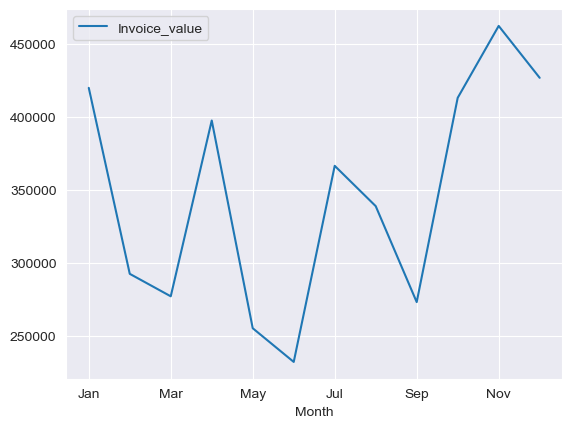

In [93]:
df3 =df3.sort_index()
df3.plot(x='Month', y= 'Invoice_value', kind ="line") # by below graph we can say by month by month revenue increases.

### 2.7  how number order varies and sales withdifferent days?

<Axes: xlabel='tx_day'>

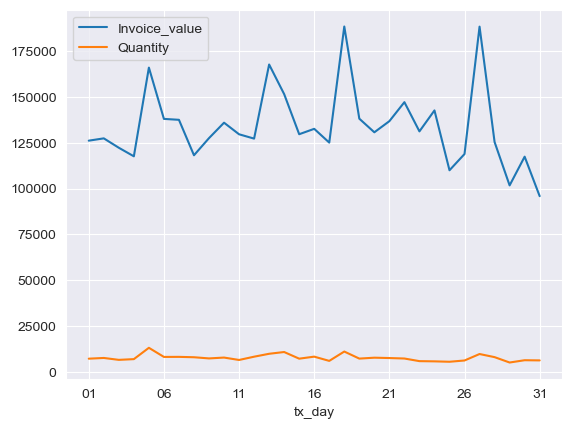

In [94]:
sales= pd.DataFrame(df_fin.groupby('tx_day').agg({"Invoice_value": sum , 'Quantity': sum})).reset_index()
sales.plot(x='tx_day', y= ['Invoice_value', 'Quantity'], kind ="line")

### 2.8  Calculate the revenue, marketing spend, percentage of makreting spend out revenue , tax, percentage of delivery charges by month

In [95]:
markt.head()

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


In [96]:
markt.Date = pd.to_datetime(markt.Date)
markt ['Month'] = markt.Date.dt.strftime("%b")

#### Marketing spend,  Revenue,  Percentage of makreting spend out revenue

In [97]:
Marketing_spend = markt.groupby('Month').agg({'Offline_Spend' : sum, 'Online_Spend' : sum})
Marketing_spend

,Offline_Spend,Online_Spend
Month,,
Apr,96000,61026.83
Aug,85500,57404.15
Dec,122000,76648.75
Feb,81300,55807.92
Jan,96600,58328.95
Jul,67500,52717.85
Jun,80500,53818.14
Mar,73500,48750.09
May,65500,52759.64


In [98]:
Monthly_Revenue.reset_index(inplace = True)
Revenue_Spend = pd.merge(Monthly_Revenue, Marketing_spend, left_on = 'tx_month', right_on= 'Month', how= "inner")
Revenue_Spend.rename(columns= {'Invoice_value': "revenue"}, inplace  =True)
Revenue_Spend['Total_Marketing_Spend'] = Revenue_Spend.Offline_Spend + Revenue_Spend.Online_Spend
Revenue_Spend['%of_marketing_spend_out_of_revenue']= (Revenue_Spend['Total_Marketing_Spend'] / Revenue_Spend["revenue"])*100

In [99]:
Revenue_Spend

,tx_year,tx_month,revenue,ActiveCustomers,MonthlyOrderCount,MonthlyOrderAverage,Offline_Spend,Online_Spend,Total_Marketing_Spend,%of_marketing_spend_out_of_revenue
0,2019,Apr,171336.81,224,24922,96.968724,96000,61026.83,157026.83,91.648041
1,2019,Aug,138596.02,300,27379,55.417042,85500,57404.15,142904.15,103.108408
2,2019,Dec,150221.36,236,12667,94.764340,122000,76648.75,198648.75,132.237353
3,2019,Feb,187524.41,109,16410,90.083079,81300,55807.92,137107.92,73.114705
4,2019,Jan,336241.33,215,19987,104.339140,96600,58328.95,154928.95,46.076712
5,2019,Jul,101326.30,235,22613,70.502334,67500,52717.85,120217.85,118.644271
6,2019,Jun,124574.99,259,21482,55.773811,80500,53818.14,134318.14,107.821112
7,2019,Mar,185524.82,208,20543,64.549853,73500,48750.09,122250.09,65.894197
8,2019,May,124403.62,200,18519,56.474198,65500,52759.64,118259.64,95.061253
9,2019,Nov,174687.97,188,15116,116.803475,93000,68144.96,161144.96,92.247314


In [100]:
df_fin.columns

Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Bags', 'Product_Category_Bottles',
       'Product_Category_Drinkware', 'Product_Category_Gift Cards',
       'Product_Category_Headgear', 'Product_Category_Housewares',
       'Product_Category_Lifestyle', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'Month', 'Coupon_Code', 'Transaction_Date',
       'Invoice_value', 'tx_month', 'tx_year', 'tx_day', 'First_tx_Date',
       'customer_type'],
      dtype='object')

#### Tax by month

In [101]:
df['Invoice_value'] = df['Quantity']*df['Avg_Price']*1-df['Discount_pct']*1+df['GST']+df.Delivery_Charges

In [102]:
df.groupby(['Product_Category', 'GST']).Invoice_value.sum()

Product_Category      GST 
Accessories           0.10       5256.55
Android               0.10        202.02
Apparel               0.18     407982.92
Bags                  0.18     140098.24
Bottles               0.05       5192.02
Drinkware             0.18     182242.95
Gift Cards            0.05      16961.77
Headgear              0.05      45853.53
Housewares            0.12       4388.97
Lifestyle             0.18      58598.42
Nest                  0.05     484946.20
Nest-Canada           0.10      67565.05
Nest-USA              0.10    2376773.75
Notebooks & Journals  0.05     109052.57
Office                0.10     247523.61
Waze                  0.18        475.32
Name: Invoice_value, dtype: float64

#### Percentage of delivery charges by Month

In [103]:
df_fin.Delivery_Charges.sum()

550289.85

In [104]:
(df_fin.groupby('tx_month').Delivery_Charges.sum()/df_fin.Delivery_Charges.sum())*100

tx_month
Apr     7.437858
Aug    11.011470
Dec     6.884007
Feb     8.805229
Jan    10.612907
Jul     8.727061
Jun     6.733877
Mar    10.780553
May     7.404460
Nov     5.867441
Oct     8.327759
Sep     7.407380
Name: Delivery_Charges, dtype: float64

### 2.9 How marketing spend is imapacting on revenues?

In [105]:
df4 = Revenue_Spend.iloc[:, [1,2,8]]
df4.sort_values(by= 'revenue')

,tx_month,revenue,Total_Marketing_Spend
11,Sep,98524.53,135514.54
5,Jul,101326.30,120217.85
8,May,124403.62,118259.64
6,Jun,124574.99,134318.14
1,Aug,138596.02,142904.15
2,Dec,150221.36,198648.75
0,Apr,171336.81,157026.83
9,Nov,174687.97,161144.96
10,Oct,178386.40,151224.65
7,Mar,185524.82,122250.09


In [106]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df4.index = pd.CategoricalIndex(df4['tx_month'], categories= sort_order, ordered  = True)
print(df4)

         tx_month    revenue  Total_Marketing_Spend
tx_month                                           
Apr           Apr  171336.81              157026.83
Aug           Aug  138596.02              142904.15
Dec           Dec  150221.36              198648.75
Feb           Feb  187524.41              137107.92
Jan           Jan  336241.33              154928.95
Jul           Jul  101326.30              120217.85
Jun           Jun  124574.99              134318.14
Mar           Mar  185524.82              122250.09
May           May  124403.62              118259.64
Nov           Nov  174687.97              161144.96
Oct           Oct  178386.40              151224.65
Sep           Sep   98524.53              135514.54


<Axes: xlabel='tx_month'>

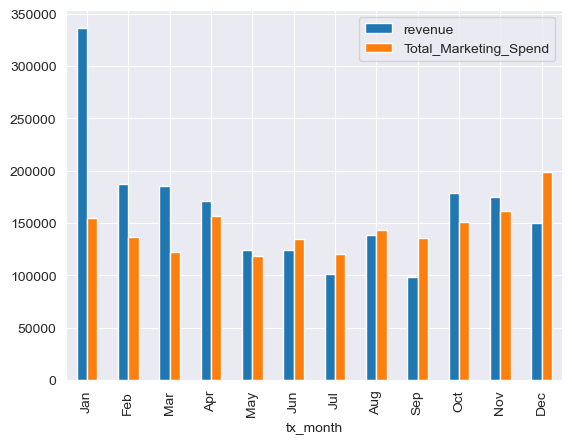

In [107]:
df4 = df4.sort_index()
df4.plot(x= 'tx_month', y= ['revenue', 'Total_Marketing_Spend'], kind= 'bar')

###### As we can see by above dataframe, if we increase in marketing spend then revenue automatically increases.

### 2.10 which product was appeared in the transactions?

In [108]:
df.groupby("Product_Category").Invoice_value.sum().sort_values(ascending = False)

Product_Category
Nest-USA                2376773.75
Nest                     484946.20
Apparel                  407982.92
Office                   247523.61
Drinkware                182242.95
Bags                     140098.24
Notebooks & Journals     109052.57
Nest-Canada               67565.05
Lifestyle                 58598.42
Headgear                  45853.53
Gift Cards                16961.77
Accessories                5256.55
Bottles                    5192.02
Housewares                 4388.97
Waze                        475.32
Android                     202.02
Name: Invoice_value, dtype: float64

##### The most Nest-USA product Category apperead most in tranasctions

### 2.11 Which product was purchased mostly based on the quantity?

In [109]:
df.groupby("Product_Category").Quantity.sum().sort_values(ascending = False)

Product_Category
Office                  88383
Apparel                 32438
Drinkware               30501
Lifestyle               24881
Nest-USA                21430
Bags                    15273
Notebooks & Journals     9556
Headgear                 3533
Nest                     2837
Housewares               2484
Bottles                  2090
Waze                     1144
Accessories              1097
Nest-Canada               469
Gift Cards                206
Android                    45
Name: Quantity, dtype: int64

#### The office products purchased mostly based on quantity.

## 3 . Performing Customer Segmentation

#### 3.1 Heuristic (Value Based, RFM) - Divide the customers into Premium, Gold, Silver, Standard customers and  define strategy on the same.

## Value based

In [110]:
# Value based segmentation (3 groups, 5 groups, 10 groups) based on the cut-offs
# Deciles creations (segments) - segmentation - 10 groups by taking cut-offs p10, p20, p30....p90
df_fin.columns

Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Bags', 'Product_Category_Bottles',
       'Product_Category_Drinkware', 'Product_Category_Gift Cards',
       'Product_Category_Headgear', 'Product_Category_Housewares',
       'Product_Category_Lifestyle', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'Month', 'Coupon_Code', 'Transaction_Date',
       'Invoice_value', 'tx_month', 'tx_year', 'tx_day', 'First_tx_Date',
       'customer_type'],
      dtype='object')

In [111]:
print('Min Invoice Date:',df_fin.Transaction_Date.dt.date.min(),'max Invoice Date:',
       df_fin.Transaction_Date.dt.date.max())

Min Invoice Date: 2019-01-01 max Invoice Date: 2019-12-31


In [112]:
snapshot_date = df_fin['Transaction_Date'].max() + dt.timedelta(days=1)
snapshot_date
#The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, 
#let's set one day after the last one,or 
#10 DEC as a snapshot_date. We will cound the diff days with snapshot_date.

Timestamp('2020-01-01 00:00:00')

In [113]:
# Calculate RFM metrics
rfm = df_fin.groupby(['CustomerID']).agg({'Transaction_Date': lambda x : (snapshot_date - x.max()).days,
                                      'Transaction_ID':'count','Invoice_value': 'sum'})
#Function Lambdea: it gives the number of days between hypothetical today and the last transaction

#Rename columns
rfm.rename(columns={'Transaction_Date':'Recency','Transaction_ID':'Frequency','Invoice_value':'MonetaryValue'}
           ,inplace= True)

#Final RFM values
rfm.reset_index(inplace=True)

In [114]:
rfm

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,108,2,121.27
1,12347,60,59,12998.83
2,12348,74,23,1072.69
3,12350,18,17,980.11
4,12356,108,36,1005.30
...,...,...,...,...
1463,18259,271,6,739.53
1464,18260,88,39,2075.54
1465,18269,195,8,54.42
1466,18277,70,1,294.10


In [115]:
rfm.MonetaryValue.quantile([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90])

0.1     110.753
0.2     377.280
0.3     673.638
0.4    1026.852
0.5    1532.705
0.6    2088.666
0.7    2866.326
0.8    4259.488
0.9    6659.308
Name: MonetaryValue, dtype: float64

In [116]:
df_fin = pd.merge(df_fin, rfm, on= 'CustomerID', how= "inner")
df_fin['Deciles'] = pd.qcut(df_fin.MonetaryValue, 10, labels=False)
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles
0,17850,16679,1,153.71,6.5,12,0.1,10,False,False,...,150.31,Jan,2019,01,2019-01-01,New,340,293,34643.33,9
1,17850,16680,1,153.71,6.5,12,0.1,10,False,False,...,150.31,Jan,2019,01,2019-01-01,New,340,293,34643.33,9
2,17850,16696,2,122.77,6.5,12,0.1,10,False,False,...,242.14,Jan,2019,01,2019-01-01,New,340,293,34643.33,9
3,17850,16699,1,81.50,6.5,12,0.1,10,False,False,...,78.10,Jan,2019,01,2019-01-01,New,340,293,34643.33,9
4,17850,16700,1,153.71,6.5,12,0.1,10,False,False,...,150.31,Jan,2019,01,2019-01-01,New,340,293,34643.33,9


In [117]:
df_fin.Deciles.value_counts()

Deciles
8    5350
4    5335
3    5264
0    5260
2    5257
5    5252
1    5246
6    5232
7    5232
9    5096
Name: count, dtype: int64

In [119]:
df_fin.columns

Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Bags', 'Product_Category_Bottles',
       'Product_Category_Drinkware', 'Product_Category_Gift Cards',
       'Product_Category_Headgear', 'Product_Category_Housewares',
       'Product_Category_Lifestyle', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'Month', 'Coupon_Code', 'Transaction_Date',
       'Invoice_value', 'tx_month', 'tx_year', 'tx_day', 'First_tx_Date',
       'customer_type', 'Recency', 'Frequency',

In [120]:
#profiling
# Key performace variable selection
col_kpi=['MonetaryValue','Recency','Frequency','Quantity',
         'GST']
profiling_output= df_fin.groupby(['Deciles']).apply(lambda x: x[col_kpi].mean()).T
profiling_output

Deciles,0,1,2,3,4,5,6,7,8,9
MonetaryValue,493.040983,1386.826685,2229.617774,3107.587905,4192.284553,5461.585221,7044.859216,9165.710424,13958.443721,42585.180589
Recency,161.610456,149.152688,135.705916,130.369111,119.169072,143.531607,111.608180,75.552561,77.671963,57.049254
Frequency,16.457795,26.579870,35.505612,48.384878,59.774883,72.921935,87.184633,117.655963,167.764860,444.861460
Quantity,3.084601,3.970644,4.092829,4.364552,4.660169,4.126428,4.712347,4.206040,5.205794,6.627747
GST,0.145871,0.140669,0.137953,0.137065,0.133747,0.136596,0.133414,0.135786,0.135585,0.137720


# RFM Segmenttion

In [121]:
df_fin

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Invoice_value,tx_month,tx_year,tx_day,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles
0,17850,16679,1,153.71,6.5,12,0.10,10,False,False,...,150.31,Jan,2019,01,2019-01-01,New,340,293,34643.33,9
1,17850,16680,1,153.71,6.5,12,0.10,10,False,False,...,150.31,Jan,2019,01,2019-01-01,New,340,293,34643.33,9
2,17850,16696,2,122.77,6.5,12,0.10,10,False,False,...,242.14,Jan,2019,01,2019-01-01,New,340,293,34643.33,9
3,17850,16699,1,81.50,6.5,12,0.10,10,False,False,...,78.10,Jan,2019,01,2019-01-01,New,340,293,34643.33,9
4,17850,16700,1,153.71,6.5,12,0.10,10,False,False,...,150.31,Jan,2019,01,2019-01-01,New,340,293,34643.33,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,12990,46843,1,355.74,6.5,47,0.05,30,False,False,...,332.29,Dec,2019,14,2019-12-14,New,18,3,486.20,0
52520,12990,46843,2,49.95,6.5,47,0.05,30,False,False,...,76.45,Dec,2019,14,2019-12-14,New,18,3,486.20,0
52521,16333,47144,1,355.74,6.5,41,0.05,30,False,False,...,332.29,Dec,2019,16,2019-12-16,New,16,2,558.59,0
52522,16333,47144,5,49.95,6.5,41,0.05,30,False,False,...,226.30,Dec,2019,16,2019-12-16,New,16,2,558.59,0


In [122]:
quantiles = df_fin[['Frequency','MonetaryValue','Recency' ]].quantile(q=[0.33,0.67])
quantiles

,Frequency,MonetaryValue,Recency
0.33,42.0,2882.40,48.0
0.67,93.0,7275.82,143.0


In [123]:
df_fin['r_seg'] = np.where(df_fin.Recency<=48, 'Active', np.where(df_fin.Recency<=143, 'At Risk', 'Churn'))
df_fin['f_seg'] = np.where(df_fin.Frequency<=42, 1, np.where(df_fin.Frequency<=93, 2, 3))
df_fin['m_seg'] = np.where(df_fin.MonetaryValue<=2882.40, 1, np.where(df_fin.MonetaryValue<=7275.82, 2, 3))
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,tx_day,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg
0,17850,16679,1,153.71,6.5,12,0.1,10,False,False,...,01,2019-01-01,New,340,293,34643.33,9,Churn,3,3
1,17850,16680,1,153.71,6.5,12,0.1,10,False,False,...,01,2019-01-01,New,340,293,34643.33,9,Churn,3,3
2,17850,16696,2,122.77,6.5,12,0.1,10,False,False,...,01,2019-01-01,New,340,293,34643.33,9,Churn,3,3
3,17850,16699,1,81.50,6.5,12,0.1,10,False,False,...,01,2019-01-01,New,340,293,34643.33,9,Churn,3,3
4,17850,16700,1,153.71,6.5,12,0.1,10,False,False,...,01,2019-01-01,New,340,293,34643.33,9,Churn,3,3


In [124]:
df_fin['fm_seg'] = np.where(((df_fin.f_seg == 3) & (df_fin.m_seg ==3)) , 'Platinum',
                          np.where((((df_fin.f_seg == 3) & (df_fin.m_seg ==2)) | ((df_fin.f_seg == 2) & (df_fin.m_seg ==3))) , 'Gold',
                          np.where((((df_fin.f_seg == 1) & (df_fin.m_seg ==3)) | ((df_fin.f_seg == 3) & (df_fin.m_seg ==1)) | ((df_fin.f_seg == 2) & (df_fin.m_seg ==2))), 'Silver', 'Standard' )))
df_fin.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg,fm_seg
0,17850,16679,1,153.71,6.5,12,0.1,10,False,False,...,2019-01-01,New,340,293,34643.33,9,Churn,3,3,Platinum
1,17850,16680,1,153.71,6.5,12,0.1,10,False,False,...,2019-01-01,New,340,293,34643.33,9,Churn,3,3,Platinum
2,17850,16696,2,122.77,6.5,12,0.1,10,False,False,...,2019-01-01,New,340,293,34643.33,9,Churn,3,3,Platinum
3,17850,16699,1,81.50,6.5,12,0.1,10,False,False,...,2019-01-01,New,340,293,34643.33,9,Churn,3,3,Platinum
4,17850,16700,1,153.71,6.5,12,0.1,10,False,False,...,2019-01-01,New,340,293,34643.33,9,Churn,3,3,Platinum


In [125]:
df_fin[(df_fin.r_seg=='Active') & (df_fin.fm_seg == 'Platinum')]

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,First_tx_Date,customer_type,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg,fm_seg
442,15311,16748,1,153.71,6.5,40,0.10,10,False,False,...,2019-01-02,New,13,583,68002.09,9,Active,3,3,Platinum
443,15311,16753,3,81.50,6.5,40,0.10,10,False,False,...,2019-01-02,New,13,583,68002.09,9,Active,3,3,Platinum
444,15311,16754,1,153.71,6.5,40,0.10,10,False,False,...,2019-01-02,New,13,583,68002.09,9,Active,3,3,Platinum
445,15311,16755,1,122.77,6.5,40,0.10,10,False,False,...,2019-01-02,New,13,583,68002.09,9,Active,3,3,Platinum
446,15311,16756,1,153.71,6.5,40,0.10,10,False,False,...,2019-01-02,New,13,583,68002.09,9,Active,3,3,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51590,17337,47029,6,24.45,6.0,44,0.18,30,False,False,...,2019-12-14,Existing,17,260,30395.20,9,Active,3,3,Platinum
51591,17337,47057,2,24.45,75.0,44,0.18,30,False,False,...,2019-12-14,Existing,17,260,30395.20,9,Active,3,3,Platinum
51592,17337,47057,2,24.45,75.0,44,0.18,30,False,False,...,2019-12-14,Existing,17,260,30395.20,9,Active,3,3,Platinum
51593,17337,47057,1,24.45,75.0,44,0.18,30,False,False,...,2019-12-14,Existing,17,260,30395.20,9,Active,3,3,Platinum


In [126]:
profiling_output= df_fin.groupby(['r_seg', 'fm_seg']).apply(lambda x: x[col_kpi].mean()).T
profiling_output

r_seg               Active                                          \
fm_seg                Gold      Platinum       Silver     Standard   
MonetaryValue  9400.921282  24956.516456  5318.619029  2145.924339   
Recency          27.966766     20.526243    25.181919    24.600697   
Frequency        84.804154    285.843553    64.628929    26.682230   
Quantity          8.552522      4.665279     3.402225     3.655052   
GST               0.130160      0.136371     0.131513     0.127909   

r_seg              At Risk                                          \
fm_seg                Gold      Platinum       Silver     Standard   
MonetaryValue  7287.382019  21270.942073  4749.712817  1918.625725   
Recency          99.241568     88.522781    91.876170    98.436214   
Frequency        96.429353    245.174973    65.411807    32.269253   
Quantity          4.237466      4.677433     3.883129     4.095091   
GST               0.135734      0.138738     0.137091     0.140457   

r_seg                Churn                                          
fm_seg                Gold      Platinum       Silver     Standard  
MonetaryValue  7247.751660  14414.445707  4855.600962  1719.283643  
Recency         243.511941    223.251904   238.710254   232.154180  
Frequency        92.568892    168.162133    66.103951    27.366561  
Quantity          6.236987      4.735582     5.168862     4.332063  
GST               0.140233      0.139434     0.139219     0.142258

## Scientific (Using K-Means) & Understand the profiles. Define strategy for each segment.

### Kmeans Segmentation

In [127]:
df_fin1.columns

Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Bags', 'Product_Category_Bottles',
       'Product_Category_Drinkware', 'Product_Category_Gift Cards',
       'Product_Category_Headgear', 'Product_Category_Housewares',
       'Product_Category_Lifestyle', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Product_SKU',
       'Product_Description', 'Month', 'Coupon_Code', 'Transaction_Date',
       'Invoice_value', 'tx_month', 'tx_year', 'tx_day'],
      dtype='object')

In [128]:
df_fin1.head(2)

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_Washington DC,Product_SKU,Product_Description,Month,Coupon_Code,Transaction_Date,Invoice_value,tx_month,tx_year,tx_day
0,17850,16679,1,153.71,6.5,12,0.1,10,False,False,...,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01
1,17850,16680,1,153.71,6.5,12,0.1,10,False,False,...,False,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Jan,ELEC10,2019-01-01,150.31,Jan,2019,01


In [129]:
df_fin1.dtypes

CustomerID                                        int64
Transaction_ID                                    int64
Quantity                                          int64
Avg_Price                                       float64
Delivery_Charges                                float64
Tenure_Months                                     int64
GST                                             float64
Discount_pct                                      int64
Product_Category_Android                           bool
Product_Category_Apparel                           bool
Product_Category_Bags                              bool
Product_Category_Bottles                           bool
Product_Category_Drinkware                         bool
Product_Category_Gift Cards                        bool
Product_Category_Headgear                          bool
Product_Category_Housewares                        bool
Product_Category_Lifestyle                         bool
Product_Category_Nest                           

In [130]:
df_fin1.drop(['Product_SKU', 'Product_Description',  'Month','Coupon_Code','tx_month','tx_year','tx_day','Transaction_Date'], axis =1, inplace = True)

In [131]:
df_fin1 # Drop the variables having high cardinility 

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Category_Office,Product_Category_Waze,Coupon_Status_Not Used,Coupon_Status_Used,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Invoice_value
0,17850,16679,1,153.71,6.5,12,0.10,10,False,False,...,False,False,False,True,True,True,False,False,False,150.31
1,17850,16680,1,153.71,6.5,12,0.10,10,False,False,...,False,False,False,True,True,True,False,False,False,150.31
2,13047,16684,2,122.77,6.5,43,0.10,10,False,False,...,False,False,False,False,True,False,False,False,False,242.14
3,13047,16684,1,81.50,6.5,43,0.10,10,False,False,...,False,False,False,True,True,False,False,False,False,78.10
4,13047,16688,1,122.77,6.5,43,0.10,10,False,False,...,False,False,False,True,True,False,False,False,False,119.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,14044,47224,1,101.93,0.0,49,0.05,30,False,False,...,False,False,False,False,True,False,False,False,False,71.98
52520,15311,47511,2,25.48,0.0,40,0.05,30,False,False,...,False,False,False,True,False,True,False,False,False,21.01
52521,12842,47997,1,254.82,0.0,27,0.05,30,False,False,...,False,False,False,True,False,False,True,False,False,224.87
52522,14462,48062,1,25.48,0.0,42,0.05,30,False,False,...,False,False,True,False,False,True,False,False,False,-4.47


In [132]:
df_fin1.columns

Index(['CustomerID', 'Transaction_ID', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Tenure_Months', 'GST', 'Discount_pct',
       'Product_Category_Android', 'Product_Category_Apparel',
       'Product_Category_Bags', 'Product_Category_Bottles',
       'Product_Category_Drinkware', 'Product_Category_Gift Cards',
       'Product_Category_Headgear', 'Product_Category_Housewares',
       'Product_Category_Lifestyle', 'Product_Category_Nest',
       'Product_Category_Nest-Canada', 'Product_Category_Nest-USA',
       'Product_Category_Notebooks & Journals', 'Product_Category_Office',
       'Product_Category_Waze', 'Coupon_Status_Not Used', 'Coupon_Status_Used',
       'Gender_M', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Invoice_value'],
      dtype='object')

In [133]:

df_fin1.dtypes

CustomerID                                 int64
Transaction_ID                             int64
Quantity                                   int64
Avg_Price                                float64
Delivery_Charges                         float64
Tenure_Months                              int64
GST                                      float64
Discount_pct                               int64
Product_Category_Android                    bool
Product_Category_Apparel                    bool
Product_Category_Bags                       bool
Product_Category_Bottles                    bool
Product_Category_Drinkware                  bool
Product_Category_Gift Cards                 bool
Product_Category_Headgear                   bool
Product_Category_Housewares                 bool
Product_Category_Lifestyle                  bool
Product_Category_Nest                       bool
Product_Category_Nest-Canada                bool
Product_Category_Nest-USA                   bool
Product_Category_Not

In [134]:
sc = StandardScaler()
std_model = sc.fit(df_fin1)
std_model.transform(df_fin1)

array([[ 1.41758421, -1.82169208, -0.1736214 , ..., -0.51756041,
        -0.23319779,  0.42710858],
       [ 1.41758421, -1.82157654, -0.1736214 , ..., -0.51756041,
        -0.23319779,  0.42710858],
       [-1.30081931, -1.82111436, -0.12401771, ..., -0.51756041,
        -0.23319779,  0.97766744],
       ...,
       [-1.41684528,  1.79694389, -0.1736214 , ..., -0.51756041,
        -0.23319779,  0.87412664],
       [-0.49995715,  1.80445431, -0.1736214 , ..., -0.51756041,
        -0.23319779, -0.50086158],
       [ 0.26185238,  1.83969551, -0.1736214 , ..., -0.51756041,
        -0.23319779, -0.04251219]])

In [135]:
df_fin1_scaled = pd.DataFrame(std_model.transform(df_fin1), columns = df_fin1.columns)
df_fin1_scaled

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Product_Category_Office,Product_Category_Waze,Coupon_Status_Not Used,Coupon_Status_Used,Gender_M,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Invoice_value
0,1.417584,-1.821692,-0.173621,1.578665,-0.20560,-1.049507,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,1.287828,1.370987,-0.304992,-0.51756,-0.233198,0.427109
1,1.417584,-1.821577,-0.173621,1.578665,-0.20560,-1.049507,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,1.287828,1.370987,-0.304992,-0.51756,-0.233198,0.427109
2,-1.300819,-1.821114,-0.124018,1.096404,-0.20560,1.251328,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,-0.715301,1.287828,-0.729402,-0.304992,-0.51756,-0.233198,0.977667
3,-1.300819,-1.821114,-0.173621,0.453128,-0.20560,1.251328,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,1.287828,-0.729402,-0.304992,-0.51756,-0.233198,-0.005820
4,-1.300819,-1.820652,-0.173621,1.096404,-0.20560,1.251328,-0.816167,-1.224673,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,1.287828,-0.729402,-0.304992,-0.51756,-0.233198,0.241610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,-0.736537,1.707628,-0.173621,0.771571,-0.54164,1.696651,-1.906328,1.236199,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,-0.715301,1.287828,-0.729402,-0.304992,-0.51756,-0.233198,-0.042512
52520,-0.019440,1.740789,-0.124018,-0.420055,-0.54164,1.028667,-1.906328,1.236199,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,-0.776501,1.370987,-0.304992,-0.51756,-0.233198,-0.348098
52521,-1.416845,1.796944,-0.173621,3.154667,-0.54164,0.063800,-1.906328,1.236199,-0.028624,-0.725913,...,-0.376235,-0.103247,-0.424697,1.398012,-0.776501,-0.729402,3.278770,-0.51756,-0.233198,0.874127
52522,-0.499957,1.804454,-0.173621,-0.420055,-0.54164,1.177108,-1.906328,1.236199,-0.028624,-0.725913,...,-0.376235,-0.103247,2.354619,-0.715301,-0.776501,1.370987,-0.304992,-0.51756,-0.233198,-0.500862


In [136]:
#Reduceing the variables for segmentation - 
#VIF
#Correlation metrics
#PCA

In [137]:
pca_model = PCA(n_components=16)
pca_model = pca_model.fit(df_fin1_scaled)
pca_model.explained_variance_  # Eigen values

array([3.08259051, 1.75869782, 1.44919147, 1.43240248, 1.3650816 ,
       1.30444855, 1.16972935, 1.16122923, 1.14160114, 1.07614034,
       1.06630565, 1.04301595, 1.038701  , 1.02155814, 1.01429199,
       1.00832906])

In [138]:
pca_model.explained_variance_ratio_

array([0.09943651, 0.05673111, 0.04674722, 0.04620565, 0.04403405,
       0.04207818, 0.03773249, 0.03745829, 0.03682514, 0.03471354,
       0.0343963 , 0.03364504, 0.03350585, 0.03295286, 0.03271847,
       0.03252612])

In [139]:
np.cumsum(pca_model.explained_variance_ratio_)

array([0.09943651, 0.15616762, 0.20291484, 0.24912049, 0.29315454,
       0.33523273, 0.37296521, 0.41042351, 0.44724865, 0.48196219,
       0.5163585 , 0.55000353, 0.58350938, 0.61646224, 0.64918071,
       0.68170684])

In [140]:
#number of compoents = 9
pca_model = PCA(n_components=9)

pca_model = pca_model.fit(df_fin1_scaled)

In [141]:
pca_model.explained_variance_

array([3.08259051, 1.75869782, 1.44919147, 1.43240248, 1.3650816 ,
       1.30444855, 1.16972935, 1.16122923, 1.14160114])

In [142]:
pca_model.explained_variance_ratio_

array([0.09943651, 0.05673111, 0.04674722, 0.04620565, 0.04403405,
       0.04207818, 0.03773249, 0.03745829, 0.03682514])

In [143]:
sum(pca_model.explained_variance_ratio_)

0.4472486505872245

In [144]:
PCs = pd.DataFrame(pca_model.transform(df_fin1_scaled), columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9' ])
PCs   #Pc's can be used for segmentaiton input

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-2.047808,-0.002276,-1.385617,-0.554340,2.700426,1.448492,0.150771,-0.524090,-0.391054
1,-2.047819,-0.002302,-1.385585,-0.554307,2.700381,1.448494,0.150759,-0.524087,-0.391059
2,-2.021551,0.198005,-1.560151,-0.683885,1.425434,-0.168162,0.823591,0.828574,-0.069469
3,-1.381006,0.088075,-1.052187,-1.079479,1.530760,1.294162,0.699229,1.003169,-0.050264
4,-1.772314,-0.011048,-1.260309,-0.988637,1.482971,1.305451,0.719945,0.964060,-0.052537
...,...,...,...,...,...,...,...,...,...
52519,-2.275375,-1.011760,2.843886,0.427023,0.323059,0.055786,0.002474,-0.448283,1.373005
52520,-1.576243,-0.695242,3.513893,1.024333,1.226190,1.633832,-0.711528,-1.610537,2.254068
52521,-3.705373,-1.450067,2.074544,0.447969,-0.848422,1.328029,0.143622,0.521199,4.892591
52522,-1.552030,-0.836159,3.617609,1.370451,1.384735,-1.794152,-0.694883,-1.626498,2.224692


In [145]:
#Variable reduction

Loadings =  pd.DataFrame((pca_model.components_.T * np.sqrt(pca_model.explained_variance_)).T,columns=df_fin1.columns).T

Loadings.columns= ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9']

Loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
CustomerID,0.007023,0.022684,-0.092078,-0.193863,0.106212,-0.001442,-0.058304,-0.148191,-0.253279
Transaction_ID,-0.166627,-0.299607,0.331803,0.339239,-0.455538,0.017223,-0.110082,0.026724,-0.044034
Quantity,-0.079141,0.685507,-0.235603,0.300705,-0.265066,0.011951,0.096253,-0.049771,0.035630
Avg_Price,-0.850852,-0.344205,-0.215764,0.057333,-0.009929,0.015065,-0.009518,-0.025343,-0.015893
Delivery_Charges,0.051995,0.500666,-0.160504,0.154944,-0.150605,-0.000642,0.037890,-0.092552,-0.040872
Tenure_Months,-0.005584,-0.016531,0.059430,0.134306,0.011962,0.011991,0.140215,0.236515,-0.154984
GST,0.873296,-0.170326,-0.377796,0.191760,-0.062756,0.013903,-0.097956,0.036475,-0.007949
Discount_pct,-0.031746,-0.192772,0.287818,0.279039,-0.279037,-0.000774,-0.138588,0.033939,-0.046228
Product_Category_Android,0.000614,0.007768,0.045548,-0.018246,0.042102,-0.035338,-0.005164,0.018937,0.006412
Product_Category_Apparel,0.651021,-0.364701,-0.177841,0.105482,-0.185087,0.014527,0.487729,-0.328965,0.059614


In [146]:
Loadings.to_csv('loadings1.csv')

In [147]:
#PCA can be used for any type of business problem (regressin, classificaiton, segmentation)
selected_vars = ['Invoice_value',
'Avg_Price',
'Location_Chicago',
'Coupon_Status_Used',
'Discount_pct',
'Location_Washington DC',
'Location_New Jersey',
'CustomerID',
'Tenure_Months',
]

In [148]:
final_input_segmentation = df_fin1_scaled[selected_vars]   #variable reduction
final_input_segmentation   #These variables can be used for segmentaiton input

,Invoice_value,Avg_Price,Location_Chicago,Coupon_Status_Used,Discount_pct,Location_Washington DC,Location_New Jersey,CustomerID,Tenure_Months
0,0.427109,1.578665,1.370987,1.398012,-1.224673,-0.233198,-0.304992,1.417584,-1.049507
1,0.427109,1.578665,1.370987,1.398012,-1.224673,-0.233198,-0.304992,1.417584,-1.049507
2,0.977667,1.096404,-0.729402,-0.715301,-1.224673,-0.233198,-0.304992,-1.300819,1.251328
3,-0.005820,0.453128,-0.729402,1.398012,-1.224673,-0.233198,-0.304992,-1.300819,1.251328
4,0.241610,1.096404,-0.729402,1.398012,-1.224673,-0.233198,-0.304992,-1.300819,1.251328
...,...,...,...,...,...,...,...,...,...
52519,-0.042512,0.771571,-0.729402,-0.715301,1.236199,-0.233198,-0.304992,-0.736537,1.696651
52520,-0.348098,-0.420055,1.370987,1.398012,1.236199,-0.233198,-0.304992,-0.019440,1.028667
52521,0.874127,3.154667,-0.729402,1.398012,1.236199,-0.233198,3.278770,-1.416845,0.063800
52522,-0.500862,-0.420055,1.370987,-0.715301,1.236199,-0.233198,-0.304992,-0.499957,1.177108


In [149]:
#Segmentation
km_3 = KMeans(n_clusters=3, random_state=123)
km_3 = km_3.fit(final_input_segmentation)

In [150]:
km_3.labels_

array([2, 2, 0, ..., 0, 2, 0])

In [151]:
km_3.cluster_centers_

array([[ 8.79014778e-01,  1.36503551e+00, -5.39833185e-01,
        -1.32809291e-02,  6.29064782e-03,  1.24449223e-01,
         1.22993021e-01, -8.83985490e-04,  3.29572793e-03],
       [-3.43388798e-01, -5.71285257e-01, -7.29401536e-01,
         7.22341420e-03, -3.58059377e-02,  1.08007750e-01,
         1.60836249e-01,  7.79697665e-03, -9.57376842e-03],
       [-1.23013121e-01, -1.38632713e-01,  1.37098697e+00,
        -9.45307106e-04,  4.50640455e-02, -2.33197793e-01,
        -3.04992380e-01, -1.01424641e-02,  1.09548424e-02]])

In [152]:
#MEtrics for segmentation output is good or not
km_3.inertia_  #clsuter errors

378722.2352543691

In [153]:
silhouette_score(final_input_segmentation, km_3.labels_)

0.14515632627755673

In [154]:
#Segment distribution
dd = pd.Series(km_3.labels_)
dd.value_counts()/sum(dd.value_counts())

1    0.450842
2    0.327241
0    0.221918
Name: count, dtype: float64

In [155]:
km_4 = KMeans(n_clusters=4, random_state=123).fit(final_input_segmentation)
km_5 = KMeans(n_clusters=5, random_state=123).fit(final_input_segmentation)
km_6 = KMeans(n_clusters=6, random_state=123).fit(final_input_segmentation)
km_7 = KMeans(n_clusters=7, random_state=123).fit(final_input_segmentation)
km_8 = KMeans(n_clusters=8, random_state=123).fit(final_input_segmentation)

In [156]:
df_fin1['cluster_3'] = km_3.labels_
df_fin1['cluster_4'] = km_4.labels_
df_fin1['cluster_5'] = km_5.labels_
df_fin1['cluster_6'] = km_6.labels_
df_fin1['cluster_7'] = km_7.labels_
df_fin1['cluster_8'] = km_8.labels_

In [157]:
df_fin1.head()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Location_New Jersey,Location_New York,Location_Washington DC,Invoice_value,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,17850,16679,1,153.71,6.5,12,0.1,10,False,False,...,False,False,False,150.31,2,2,0,5,5,1
1,17850,16680,1,153.71,6.5,12,0.1,10,False,False,...,False,False,False,150.31,2,2,0,5,5,1
2,13047,16684,2,122.77,6.5,43,0.1,10,False,False,...,False,False,False,242.14,0,0,0,0,0,0
3,13047,16684,1,81.50,6.5,43,0.1,10,False,False,...,False,False,False,78.10,1,1,1,1,1,1
4,13047,16688,1,122.77,6.5,43,0.1,10,False,False,...,False,False,False,119.37,0,0,1,1,1,1


In [159]:
#Choosing best solution (optimal solution) - Identifying best value of K
#1. Metrics	
    # a. Silhoutte coeficient	between -1 & 1	
        # Closer to 1, segmentation is good	
        # Closer to-1, segmentation is bad	
    # b. Pseudo F-value (Inertia/Cluster errors)	

#2. Profiling of segments			
#3. Best practices			
#   Segment distribution	4%-40%	
#   Strategy can be implementable or not

In [160]:
silhouette_score(final_input_segmentation, km_3.labels_)

0.14515632627755673

In [161]:
# calculate SC for K=3 through K=9
k_range = range(3, 9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(final_input_segmentation)
    scores.append(silhouette_score(final_input_segmentation, km.labels_))

In [162]:
scores

[0.14515632627755673,
 0.17613396029058512,
 0.17611188764926222,
 0.1639762664749888,
 0.19827477755500336,
 0.19186769238581]

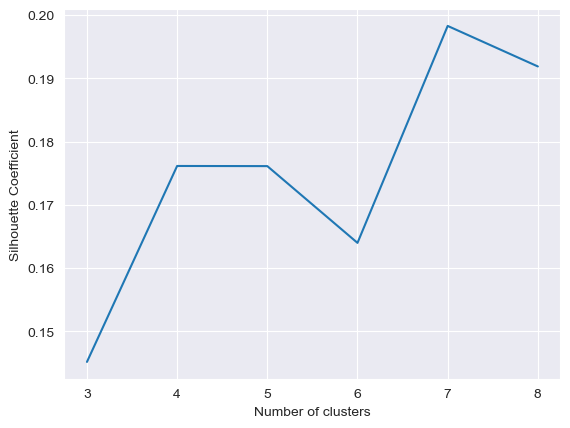

In [163]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [164]:
#based on sc score, the solution K=4, the second solution can be k=8
df_fin1.cluster_3.value_counts()/sum(df_fin1.cluster_3.value_counts())

cluster_3
1    0.450842
2    0.327241
0    0.221918
Name: count, dtype: float64

In [165]:
sum(df_fin1.cluster_5.value_counts())

52524

In [166]:
df_fin1.cluster_4.value_counts()/sum(df_fin1.cluster_3.value_counts())

cluster_4
1    0.392430
2    0.325242
0    0.198176
3    0.084152
Name: count, dtype: float64

In [167]:
df_fin1.cluster_5.value_counts()/sum(df_fin1.cluster_3.value_counts())

cluster_5
4    0.273589
2    0.262927
0    0.197281
1    0.181707
3    0.084495
Name: count, dtype: float64

In [168]:
#Profiling
size=pd.concat([pd.Series(df_fin1.cluster_3.size), pd.Series.sort_index(df_fin1.cluster_3.value_counts()), pd.Series.sort_index(df_fin1.cluster_4.value_counts()),
           pd.Series.sort_index(df_fin1.cluster_5.value_counts()), pd.Series.sort_index(df_fin1.cluster_6.value_counts()),
           pd.Series.sort_index(df_fin1.cluster_7.value_counts()), pd.Series.sort_index(df_fin1.cluster_8.value_counts())])

In [169]:
size

0    52524
0    11656
1    23680
2    17188
0    10409
1    20612
2    17083
3     4420
0    10362
1     9544
2    13810
3     4438
4    14370
0     8123
1     8468
2     8890
3     4414
4    14235
5     8394
0     7021
1     8613
2     8939
3     4415
4    12851
5     7978
6     2707
0     6554
1     7677
2     4877
3     4414
4     2707
5     6741
6     6742
7    12812
dtype: int64

In [170]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/df_fin1.cluster_3.size, columns=['Seg_Pct'])

In [171]:
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.221918,0.450842,0.327241,0.198176,0.39243,0.325242,0.084152,0.197281,0.181707,...,0.151892,0.051538,0.124781,0.146162,0.092853,0.084038,0.051538,0.128341,0.12836,0.243927


In [172]:
df_fin1.apply(np.mean).T

CustomerID                               15345.347213
Transaction_ID                           32445.093367
Quantity                                     4.500171
Avg_Price                                   52.429089
Delivery_Charges                            10.476922
Tenure_Months                               26.140393
GST                                          0.137433
Discount_pct                                19.953164
Product_Category_Android                     0.000819
Product_Category_Apparel                     0.345099
Product_Category_Bags                        0.035831
Product_Category_Bottles                     0.005102
Product_Category_Drinkware                   0.066313
Product_Category_Gift Cards                  0.003027
Product_Category_Headgear                    0.014679
Product_Category_Housewares                  0.002323
Product_Category_Lifestyle                   0.058868
Product_Category_Nest                        0.041848
Product_Category_Nest-Canada

In [173]:
df_fin1.groupby('cluster_4').apply(np.mean).T

cluster_4
0    1337.454680
1    1277.790044
2    1294.320716
3    1305.043987
dtype: float64

In [174]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([df_fin1.apply(lambda x: x.mean()).T, df_fin1.groupby('cluster_3').apply(lambda x: x.mean()).T, df_fin1.groupby('cluster_4').apply(lambda x: x.mean()).T,
          df_fin1.groupby('cluster_5').apply(lambda x: x.mean()).T, df_fin1.groupby('cluster_6').apply(lambda x: x.mean()).T,
          df_fin1.groupby('cluster_7').apply(lambda x: x.mean()).T, df_fin1.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)

Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
CustomerID,15345.347213,15343.785347,15359.123269,15327.427042,15372.327793,15395.837570,15325.971902,15121.238688,15350.682687,15416.319573,...,14799.768238,15627.431474,15280.571254,15315.688550,16996.471396,15124.329633,15627.431474,14205.000297,15359.728122,15376.707696
Transaction_ID,32445.093367,33726.333648,31846.124282,32401.426344,33674.272168,31764.295896,32383.647486,32962.685068,33600.910152,31949.084451,...,31153.703434,31514.887699,34020.554623,30691.132734,31633.370515,32952.964431,31514.887699,33015.685062,33852.927025,31979.647362
Quantity,4.500171,5.393188,4.365794,4.079707,5.411375,4.416893,4.059357,4.446380,4.862092,4.090214,...,3.965656,4.162911,6.420201,4.000782,3.903629,4.446307,4.162911,3.981308,4.290863,4.517249
Avg_Price,52.429089,140.004360,15.777690,43.534963,141.212030,15.767147,43.094267,50.393133,145.667127,43.055325,...,43.836579,55.902959,152.759619,42.549690,47.928837,50.052030,55.902959,41.562566,45.397542,18.240209
Delivery_Charges,10.476922,9.505672,11.017228,10.391190,9.651570,11.176747,10.382483,9.522079,8.941277,10.596372,...,10.087953,10.297787,10.121868,10.511506,10.594482,9.526640,10.297787,10.201661,10.341706,11.174300
Tenure_Months,26.140393,26.184798,26.011402,26.287992,26.244884,26.001019,26.294503,25.948643,26.154024,26.141345,...,25.290298,26.947543,26.392280,25.809691,18.669469,25.957635,26.947543,31.066756,27.091071,25.853731
GST,0.137433,0.094430,0.156092,0.140889,0.094116,0.155819,0.141129,0.139423,0.095184,0.140971,...,0.140342,0.136923,0.092626,0.141378,0.138858,0.139515,0.136923,0.141497,0.140246,0.153221
Discount_pct,19.953164,20.004290,19.662162,20.319409,19.952925,19.588104,20.319031,20.242081,20.113878,19.663663,...,13.352971,19.050610,20.105279,13.670705,20.463400,20.249207,19.050610,20.191366,27.125482,19.634717
Product_Category_Android,0.000819,0.000000,0.001056,0.001047,0.000000,0.001019,0.001054,0.000905,0.000000,0.000629,...,0.001379,0.000369,0.000000,0.000782,0.000820,0.000906,0.000369,0.001780,0.000297,0.001093
Product_Category_Apparel,0.345099,0.013469,0.500042,0.356528,0.013546,0.496458,0.358544,0.368100,0.009747,0.369447,...,0.350840,0.350203,0.012664,0.364986,0.337092,0.368373,0.350203,0.364783,0.359092,0.479472


In [175]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)
Profling_output_final

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,52524.000000,11656.000000,23680.000000,17188.000000,10409.000000,20612.000000,17083.000000,4420.000000,10362.000000,9544.000000,...,7978.000000,2707.000000,6554.000000,7677.000000,4877.000000,4414.000000,2707.000000,6741.000000,6742.000000,12812.000000
Seg_Pct,1.000000,0.221918,0.450842,0.327241,0.198176,0.392430,0.325242,0.084152,0.197281,0.181707,...,0.151892,0.051538,0.124781,0.146162,0.092853,0.084038,0.051538,0.128341,0.128360,0.243927
CustomerID,15345.347213,15343.785347,15359.123269,15327.427042,15372.327793,15395.837570,15325.971902,15121.238688,15350.682687,15416.319573,...,14799.768238,15627.431474,15280.571254,15315.688550,16996.471396,15124.329633,15627.431474,14205.000297,15359.728122,15376.707696
Transaction_ID,32445.093367,33726.333648,31846.124282,32401.426344,33674.272168,31764.295896,32383.647486,32962.685068,33600.910152,31949.084451,...,31153.703434,31514.887699,34020.554623,30691.132734,31633.370515,32952.964431,31514.887699,33015.685062,33852.927025,31979.647362
Quantity,4.500171,5.393188,4.365794,4.079707,5.411375,4.416893,4.059357,4.446380,4.862092,4.090214,...,3.965656,4.162911,6.420201,4.000782,3.903629,4.446307,4.162911,3.981308,4.290863,4.517249
Avg_Price,52.429089,140.004360,15.777690,43.534963,141.212030,15.767147,43.094267,50.393133,145.667127,43.055325,...,43.836579,55.902959,152.759619,42.549690,47.928837,50.052030,55.902959,41.562566,45.397542,18.240209
Delivery_Charges,10.476922,9.505672,11.017228,10.391190,9.651570,11.176747,10.382483,9.522079,8.941277,10.596372,...,10.087953,10.297787,10.121868,10.511506,10.594482,9.526640,10.297787,10.201661,10.341706,11.174300
Tenure_Months,26.140393,26.184798,26.011402,26.287992,26.244884,26.001019,26.294503,25.948643,26.154024,26.141345,...,25.290298,26.947543,26.392280,25.809691,18.669469,25.957635,26.947543,31.066756,27.091071,25.853731
GST,0.137433,0.094430,0.156092,0.140889,0.094116,0.155819,0.141129,0.139423,0.095184,0.140971,...,0.140342,0.136923,0.092626,0.141378,0.138858,0.139515,0.136923,0.141497,0.140246,0.153221
Discount_pct,19.953164,20.004290,19.662162,20.319409,19.952925,19.588104,20.319031,20.242081,20.113878,19.663663,...,13.352971,19.050610,20.105279,13.670705,20.463400,20.249207,19.050610,20.191366,27.125482,19.634717


In [176]:
#Profling_output_final.columns = ['Seg_' + str(i) for i in Profling_output_final.columns]
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,52524.000000,11656.000000,23680.000000,17188.000000,10409.000000,20612.000000,17083.000000,4420.000000,10362.000000,9544.000000,...,7978.000000,2707.000000,6554.000000,7677.000000,4877.000000,4414.000000,2707.000000,6741.000000,6742.000000,12812.000000
Seg_Pct,1.000000,0.221918,0.450842,0.327241,0.198176,0.392430,0.325242,0.084152,0.197281,0.181707,...,0.151892,0.051538,0.124781,0.146162,0.092853,0.084038,0.051538,0.128341,0.128360,0.243927
CustomerID,15345.347213,15343.785347,15359.123269,15327.427042,15372.327793,15395.837570,15325.971902,15121.238688,15350.682687,15416.319573,...,14799.768238,15627.431474,15280.571254,15315.688550,16996.471396,15124.329633,15627.431474,14205.000297,15359.728122,15376.707696
Transaction_ID,32445.093367,33726.333648,31846.124282,32401.426344,33674.272168,31764.295896,32383.647486,32962.685068,33600.910152,31949.084451,...,31153.703434,31514.887699,34020.554623,30691.132734,31633.370515,32952.964431,31514.887699,33015.685062,33852.927025,31979.647362
Quantity,4.500171,5.393188,4.365794,4.079707,5.411375,4.416893,4.059357,4.446380,4.862092,4.090214,...,3.965656,4.162911,6.420201,4.000782,3.903629,4.446307,4.162911,3.981308,4.290863,4.517249
Avg_Price,52.429089,140.004360,15.777690,43.534963,141.212030,15.767147,43.094267,50.393133,145.667127,43.055325,...,43.836579,55.902959,152.759619,42.549690,47.928837,50.052030,55.902959,41.562566,45.397542,18.240209
Delivery_Charges,10.476922,9.505672,11.017228,10.391190,9.651570,11.176747,10.382483,9.522079,8.941277,10.596372,...,10.087953,10.297787,10.121868,10.511506,10.594482,9.526640,10.297787,10.201661,10.341706,11.174300
Tenure_Months,26.140393,26.184798,26.011402,26.287992,26.244884,26.001019,26.294503,25.948643,26.154024,26.141345,...,25.290298,26.947543,26.392280,25.809691,18.669469,25.957635,26.947543,31.066756,27.091071,25.853731
GST,0.137433,0.094430,0.156092,0.140889,0.094116,0.155819,0.141129,0.139423,0.095184,0.140971,...,0.140342,0.136923,0.092626,0.141378,0.138858,0.139515,0.136923,0.141497,0.140246,0.153221
Discount_pct,19.953164,20.004290,19.662162,20.319409,19.952925,19.588104,20.319031,20.242081,20.113878,19.663663,...,13.352971,19.050610,20.105279,13.670705,20.463400,20.249207,19.050610,20.191366,27.125482,19.634717


In [177]:
Profling_output_final.to_csv('Profling_output_final.csv')

# Elbow Analysis 

In [178]:
cluster_range = range( 1, 12 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( df_fin1_scaled )
    cluster_errors.append( clusters.inertia_ )

In [179]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df

,num_clusters,cluster_errors
0,1,1.628244e+06
1,2,1.489002e+06
2,3,1.439097e+06
3,4,1.376603e+06
4,5,1.304454e+06
5,6,1.216407e+06
6,7,1.167761e+06
7,8,1.105440e+06
8,9,1.123301e+06
9,10,1.090146e+06


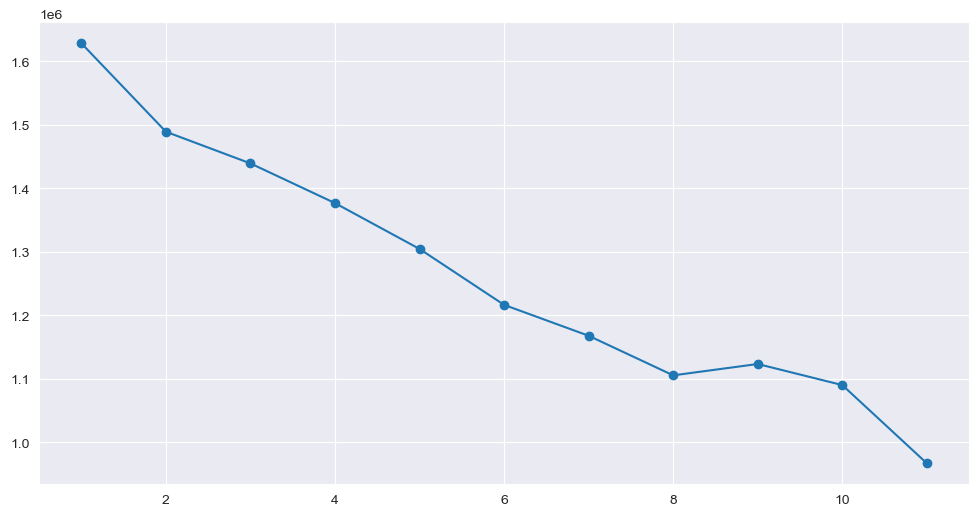

In [180]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

# Note:
- The elbow diagram shows that the gain in explained variance reduces significantly from 3 to 4 to 5. So, optimal number of clusters could either 4 or 5. 
- The actual number of clusters chosen can be finally based on business context and convenience of dealing with number of segments or clusters.

In [181]:
import pickle

# now you can save it to a file
with open('km_4model.pkl', 'wb') as f:
    pickle.dump(km_4, f)

### 4. Predicting Customer Lifetime Value (Low Value/Medium Value/High Value) 
####  First define dependent variable with categories low value, medium value, high value using customer revenue.

In [182]:
rfm

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,108,2,121.27
1,12347,60,59,12998.83
2,12348,74,23,1072.69
3,12350,18,17,980.11
4,12356,108,36,1005.30
...,...,...,...,...
1463,18259,271,6,739.53
1464,18260,88,39,2075.54
1465,18269,195,8,54.42
1466,18277,70,1,294.10


In [183]:
quantiles_1 = rfm[['MonetaryValue' ]].quantile(q=[0.33,0.67])
quantiles_1

,MonetaryValue
0.33,755.3872
0.67,2624.7315


In [184]:
# Creating dependent variable 

In [185]:
rfm['Customer_flag_based_on_revenue'] = np.where(rfm.MonetaryValue<=755.3872, 'Low_Value', np.where(rfm.MonetaryValue<=2624.7315, "Medium_Value", "High_Value"))

In [186]:
rfm

,CustomerID,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue
0,12346,108,2,121.27,Low_Value
1,12347,60,59,12998.83,High_Value
2,12348,74,23,1072.69,Medium_Value
3,12350,18,17,980.11,Medium_Value
4,12356,108,36,1005.30,Medium_Value
...,...,...,...,...,...
1463,18259,271,6,739.53,Low_Value
1464,18260,88,39,2075.54,Medium_Value
1465,18269,195,8,54.42,Low_Value
1466,18277,70,1,294.10,Low_Value


In [187]:
df_fin_CLTV.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months', 'GST', 'Month', 'Coupon_Code', 'Discount_pct',
       'Invoice_value'],
      dtype='object')

In [188]:
df_fin_CLTV.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Invoice_value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
2,13047,16684,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Clicked,M,California,43,0.1,Jan,ELEC10,10,242.14
3,13047,16684,2019-01-01,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,1,81.50,6.5,Used,M,California,43,0.1,Jan,ELEC10,10,78.10
4,13047,16688,2019-01-01,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,122.77,6.5,Used,M,California,43,0.1,Jan,ELEC10,10,119.37


In [189]:
customer_level_data = df_fin_CLTV.groupby(['CustomerID','Location','Gender']).agg({'Transaction_Date': min, 'Quantity' : sum, 'Avg_Price': sum , 'Delivery_Charges': sum, 'GST': sum}).reset_index()

In [190]:
customer_level_data.head()

,CustomerID,Location,Gender,Transaction_Date,Quantity,Avg_Price,Delivery_Charges,GST
0,12346,New York,F,2019-09-15,3,25.49,150.00,0.28
1,12347,New York,M,2019-03-24,340,3734.97,658.64,7.67
2,12348,California,M,2019-06-22,209,336.52,197.15,3.42
3,12350,California,M,2019-12-14,21,1312.40,127.88,2.16
4,12356,Chicago,F,2019-09-15,56,1244.83,637.49,5.34


In [191]:
data_final = pd.merge(customer_level_data, rfm, on = "CustomerID", how= "left")
data_final.Customer_flag_based_on_revenue.value_counts()

Customer_flag_based_on_revenue
Medium_Value    498
Low_Value       485
High_Value      485
Name: count, dtype: int64

In [192]:
data_final.isna().sum()

CustomerID                        0
Location                          0
Gender                            0
Transaction_Date                  0
Quantity                          0
Avg_Price                         0
Delivery_Charges                  0
GST                               0
Recency                           0
Frequency                         0
MonetaryValue                     0
Customer_flag_based_on_revenue    0
dtype: int64

In [193]:
data_final.duplicated().sum()

0

In [194]:
data_final.columns

Index(['CustomerID', 'Location', 'Gender', 'Transaction_Date', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'GST', 'Recency', 'Frequency',
       'MonetaryValue', 'Customer_flag_based_on_revenue'],
      dtype='object')

In [195]:
# We already created dummies for Location, Gender, Coupan_Status 
data_final.dtypes

CustomerID                                 int64
Location                                  object
Gender                                    object
Transaction_Date                  datetime64[ns]
Quantity                                   int64
Avg_Price                                float64
Delivery_Charges                         float64
GST                                      float64
Recency                                    int64
Frequency                                  int64
MonetaryValue                            float64
Customer_flag_based_on_revenue            object
dtype: object

In [196]:
data_final.nunique()

CustomerID                        1468
Location                             5
Gender                               2
Transaction_Date                   345
Quantity                           440
Avg_Price                         1443
Delivery_Charges                  1150
GST                                775
Recency                            335
Frequency                          162
MonetaryValue                     1463
Customer_flag_based_on_revenue       3
dtype: int64

In [197]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   CustomerID                      1468 non-null   int64         
 1   Location                        1468 non-null   object        
 2   Gender                          1468 non-null   object        
 3   Transaction_Date                1468 non-null   datetime64[ns]
 4   Quantity                        1468 non-null   int64         
 5   Avg_Price                       1468 non-null   float64       
 6   Delivery_Charges                1468 non-null   float64       
 7   GST                             1468 non-null   float64       
 8   Recency                         1468 non-null   int64         
 9   Frequency                       1468 non-null   int64         
 10  MonetaryValue                   1468 non-null   float64       
 11  Cust

In [198]:
data_final.columns   # As dummy creation already done for product_category, coupon_status, gender, location

Index(['CustomerID', 'Location', 'Gender', 'Transaction_Date', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'GST', 'Recency', 'Frequency',
       'MonetaryValue', 'Customer_flag_based_on_revenue'],
      dtype='object')

In [199]:
data_final.head()

,CustomerID,Location,Gender,Transaction_Date,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue
0,12346,New York,F,2019-09-15,3,25.49,150.00,0.28,108,2,121.27,Low_Value
1,12347,New York,M,2019-03-24,340,3734.97,658.64,7.67,60,59,12998.83,High_Value
2,12348,California,M,2019-06-22,209,336.52,197.15,3.42,74,23,1072.69,Medium_Value
3,12350,California,M,2019-12-14,21,1312.40,127.88,2.16,18,17,980.11,Medium_Value
4,12356,Chicago,F,2019-09-15,56,1244.83,637.49,5.34,108,36,1005.30,Medium_Value


In [202]:
data_final.head()

,Location,Gender,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue
0,New York,F,3,25.49,150.00,0.28,108,2,121.27,Low_Value
1,New York,M,340,3734.97,658.64,7.67,60,59,12998.83,High_Value
2,California,M,209,336.52,197.15,3.42,74,23,1072.69,Medium_Value
3,California,M,21,1312.40,127.88,2.16,18,17,980.11,Medium_Value
4,Chicago,F,56,1244.83,637.49,5.34,108,36,1005.30,Medium_Value


In [203]:
#Creating dummies

In [204]:
data_final = create_dummies(data_final, ['Location','Gender'])

In [205]:
data_final

,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Customer_flag_based_on_revenue,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Gender_F,Gender_M
0,3,25.49,150.00,0.28,108,2,121.27,Low_Value,False,False,True,False,True,False
1,340,3734.97,658.64,7.67,60,59,12998.83,High_Value,False,False,True,False,False,True
2,209,336.52,197.15,3.42,74,23,1072.69,Medium_Value,False,False,False,False,False,True
3,21,1312.40,127.88,2.16,18,17,980.11,Medium_Value,False,False,False,False,False,True
4,56,1244.83,637.49,5.34,108,36,1005.30,Medium_Value,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,45,67.14,271.83,0.95,271,6,739.53,Low_Value,False,False,False,False,True,False
1464,128,1111.29,614.06,5.23,88,39,2075.54,Medium_Value,False,False,True,False,False,True
1465,10,89.34,51.50,1.36,195,8,54.42,Low_Value,True,False,False,False,False,True
1466,2,149.00,6.00,0.10,70,1,294.10,Low_Value,True,False,False,False,True,False


In [230]:
#splitting 
X = data_final.drop(columns = ['Customer_flag_based_on_revenue'])
y = data_final["Customer_flag_based_on_revenue"]

In [231]:
y

0          Low_Value
1         High_Value
2       Medium_Value
3       Medium_Value
4       Medium_Value
            ...     
1463       Low_Value
1464    Medium_Value
1465       Low_Value
1466       Low_Value
1467      High_Value
Name: Customer_flag_based_on_revenue, Length: 1468, dtype: object

In [232]:
#Encoder for y variable
enc =LabelEncoder()
y = enc.fit_transform(y)
X


,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Gender_F,Gender_M
0,3,25.49,150.00,0.28,108,2,121.27,False,False,True,False,True,False
1,340,3734.97,658.64,7.67,60,59,12998.83,False,False,True,False,False,True
2,209,336.52,197.15,3.42,74,23,1072.69,False,False,False,False,False,True
3,21,1312.40,127.88,2.16,18,17,980.11,False,False,False,False,False,True
4,56,1244.83,637.49,5.34,108,36,1005.30,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,45,67.14,271.83,0.95,271,6,739.53,False,False,False,False,True,False
1464,128,1111.29,614.06,5.23,88,39,2075.54,False,False,True,False,False,True
1465,10,89.34,51.50,1.36,195,8,54.42,True,False,False,False,False,True
1466,2,149.00,6.00,0.10,70,1,294.10,True,False,False,False,True,False


In [233]:
X

,Quantity,Avg_Price,Delivery_Charges,GST,Recency,Frequency,MonetaryValue,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Gender_F,Gender_M
0,3,25.49,150.00,0.28,108,2,121.27,False,False,True,False,True,False
1,340,3734.97,658.64,7.67,60,59,12998.83,False,False,True,False,False,True
2,209,336.52,197.15,3.42,74,23,1072.69,False,False,False,False,False,True
3,21,1312.40,127.88,2.16,18,17,980.11,False,False,False,False,False,True
4,56,1244.83,637.49,5.34,108,36,1005.30,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,45,67.14,271.83,0.95,271,6,739.53,False,False,False,False,True,False
1464,128,1111.29,614.06,5.23,88,39,2075.54,False,False,True,False,False,True
1465,10,89.34,51.50,1.36,195,8,54.42,True,False,False,False,False,True
1466,2,149.00,6.00,0.10,70,1,294.10,True,False,False,False,True,False


In [234]:
y

array([1, 0, 2, ..., 1, 1, 0])

In [235]:
#pd.Series(y).value_counts()
#balancing the data
#sm = SMOTE()
#resampled_X, resampled_y = sm.fit_resample(X, y)
#X.shape
#y.shape
#resampled_y.shape
#resampled_X.shape
#splitting to train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [236]:
#svc = SVC(kernel='rbf', class_weight='balanced')
from sklearn.svm import SVC

param_grid = {'C': [1]}
grid = GridSearchCV(SVC(), param_grid)

grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 1}


In [237]:
model = grid.best_estimator_
yfit = model.predict(X_test)

In [238]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        96
           1       0.96      0.96      0.96       101
           2       0.93      0.96      0.94        97

    accuracy                           0.96       294
   macro avg       0.96      0.96      0.96       294
weighted avg       0.96      0.96      0.96       294



### RANDOM FOREST

In [216]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

In [218]:
online_sales = pd.read_csv("Datasets/Online_Sales.csv")
custmer = pd.read_excel("Datasets/CustomersData.xlsx")

In [219]:
data = pd.merge(online_sales, custmer, on="CustomerID", how="left")


In [220]:
data['Purchase_Date'] = pd.to_datetime(data['Transaction_Date'])  # Ensure it's in datetime format
data.sort_values(by=['CustomerID', 'Purchase_Date'], inplace=True)


In [221]:
data['Next_Purchase'] = data.groupby('CustomerID')['Purchase_Date'].shift(-1).notnull().astype(int)


In [222]:
X = data[['Quantity', 'Avg_Price', 'Delivery_Charges']]  # Add other relevant features
y = data['Next_Purchase']  # This is your target variable


In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [224]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [226]:
yfit = model.predict(X_test)

In [228]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       276
           1       0.97      1.00      0.99     10309

    accuracy                           0.97     10585
   macro avg       0.49      0.50      0.49     10585
weighted avg       0.95      0.97      0.96     10585



In [229]:
# Save the model to a file
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

print("Model saved as model.pkl")

Model saved as model.pkl


# 5. Cross-Selling (Which products are selling together)
##  You can perform exploratory analysis & market basket analysis to understand which of items can be bundled together.

In [242]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [243]:
df_fin3.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Invoice_value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
2,13047,16684,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Clicked,M,California,43,0.1,Jan,ELEC10,10,242.14
3,13047,16684,2019-01-01,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,1,81.50,6.5,Used,M,California,43,0.1,Jan,ELEC10,10,78.10
4,13047,16688,2019-01-01,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,122.77,6.5,Used,M,California,43,0.1,Jan,ELEC10,10,119.37


In [244]:
# Clean up spaces in description and remove any rows that don't have a valid invoice
df_fin3['Product_Description'] = df['Product_Description'].str.strip()
df_fin3.dropna(axis=0, subset=['Transaction_ID'], inplace=True)

In [245]:
df_fin3.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Invoice_value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
2,13047,16684,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Clicked,M,California,43,0.1,Jan,ELEC10,10,242.14
3,13047,16684,2019-01-01,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,1,81.50,6.5,Used,M,California,43,0.1,Jan,ELEC10,10,78.10
4,13047,16688,2019-01-01,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,122.77,6.5,Used,M,California,43,0.1,Jan,ELEC10,10,119.37


In [246]:
#Drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).
df_fin3['Transaction_ID'] = df_fin3['Transaction_ID'].astype('str')


In [247]:
#To keeping data set is small location= Chicago
basket = (df_fin3[df_fin3['Location'] =="Chicago"].groupby(['Transaction_ID', 'Product_Description'])['Quantity'].sum()
          .unstack().reset_index().fillna(0).set_index('Transaction_ID'))

basket.head()

Product_Description,1 oz Hand Sanitizer,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz YouTube Sergeant Stripe Bottle,26 oz Double Wall Insulated Bottle,7&quot; Dog Frisbee,8 pc Android Sticker Sheet,Android 17oz Stainless Steel Sport Bottle,...,YouTube Trucker Hat,YouTube Twill Cap,YouTube Women's Favorite Tee White,YouTube Women's Fleece Hoodie Black,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
16679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16692,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [248]:
#we need to consolidate the items into 1 transaction per row with each product 1 hot encoded.
# Convert the units to 1 hot encoded values
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1   

In [249]:
basket_sets = basket.applymap(encode_units)

In [250]:
# Build up the frequent items
#Now that the data is structured properly, we can generate frequent item sets that have a support of 
#at least 7% (this number was chosen so that I could get enough useful examples):
frequent_itemsets = apriori(basket_sets, min_support=0.001, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False)

C:\Users\amanv\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
226,0.136539,(Nest Learning Thermostat 3rd Gen-USA - Stainl...
222,0.123966,(Nest Cam Outdoor Security Camera - USA)
220,0.118893,(Nest Cam Indoor Security Camera - USA)
229,0.052939,(Nest Protect Smoke + CO White Battery Alarm-USA)
227,0.044006,(Nest Learning Thermostat 3rd Gen-USA - White)
...,...,...
307,0.001103,(Android Men's Pep Rally Short Sleeve Tee Navy...
230,0.001103,(Nest Protect Smoke + CO White Wired Alarm - CA)
309,0.001103,"(Collapsible Shopping Bag, Android Rise 14 oz ..."
310,0.001103,"(Google 22 oz Water Bottle, Android Rise 14 oz..."


In [251]:
#Generate the rules with their corresponding support, confidence and lift:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Colored Pencil Set),(1 oz Hand Sanitizer),0.007610,0.005735,0.001103,0.144928,25.270346,1.0,0.001059,1.162784,0.967793,0.090090,0.139995,0.168618
1,(1 oz Hand Sanitizer),(Colored Pencil Set),0.005735,0.007610,0.001103,0.192308,25.270346,1.0,0.001059,1.228673,0.965968,0.090090,0.186114,0.168618
2,(Google 22 oz Water Bottle),(1 oz Hand Sanitizer),0.024815,0.005735,0.001434,0.057778,10.074444,1.0,0.001291,1.055234,0.923660,0.049242,0.052343,0.153889
3,(1 oz Hand Sanitizer),(Google 22 oz Water Bottle),0.005735,0.024815,0.001434,0.250000,10.074444,1.0,0.001291,1.300246,0.905935,0.049242,0.230915,0.153889
4,(1 oz Hand Sanitizer),(Google Kick Ball),0.005735,0.012022,0.001765,0.307692,25.594919,1.0,0.001696,1.427080,0.966473,0.110345,0.299268,0.227241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,(Nest Protect Smoke + CO White Wired Alarm-USA...,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.004301,0.136539,0.001213,0.282051,2.065718,1.0,0.000626,1.202678,0.518135,0.008689,0.168522,0.145468
404,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Wired Alarm-USA),0.010036,0.042241,0.001213,0.120879,2.861647,1.0,0.000789,1.089451,0.657146,0.023758,0.082106,0.074800
405,(Nest Protect Smoke + CO White Wired Alarm-USA),(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.042241,0.010036,0.001213,0.028721,2.861647,1.0,0.000789,1.019237,0.679243,0.023758,0.018874,0.074800
406,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Wired Alarm-USA...,0.136539,0.004301,0.001213,0.008885,2.065718,1.0,0.000626,1.004625,0.597487,0.008689,0.004604,0.145468


##### That’s all there is to it! Build the frequent items using apriori then build the rules with association_rules .
#### Intrepretation: we can see that there are quite a few rules with a high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. We can also see several where the confidence is high as well. This part of the analysis is where the domain knowledge will come in handy.

In [252]:
rules.sort_values(by='confidence', ascending=False )

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
48,(Android Large Removable Sticker Sheet),(Android Small Removable Sticker Sheet),0.001985,0.003198,0.001213,0.611111,191.067050,1.0,0.001207,2.563204,0.996745,0.305556,0.609863,0.495211
337,(Nest Detect - USA),(Nest Secure Alarm System Starter Pack - USA),0.002206,0.017095,0.001323,0.600000,35.098065,1.0,0.001286,2.457263,0.973656,0.073620,0.593043,0.338710
297,(Google Tote Bag),(Sport Bag),0.002537,0.016654,0.001213,0.478261,28.717823,1.0,0.001171,1.884747,0.967633,0.067485,0.469425,0.275554
294,(Google Tee Green),(Google Tee Blue),0.006176,0.007941,0.002868,0.464286,58.467758,1.0,0.002818,1.851844,0.989005,0.254902,0.459998,0.412698
62,(Android Small Removable Sticker Sheet),(Google Laptop and Cell Phone Stickers),0.003198,0.030771,0.001434,0.448276,14.568162,1.0,0.001335,1.756728,0.934346,0.044068,0.430760,0.247435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Battery Alarm-U...,0.136539,0.005404,0.001654,0.012116,2.242013,1.0,0.000916,1.006794,0.641572,0.011792,0.006749,0.159119
407,(Nest Cam Outdoor Security Camera - USA),(Nest Protect Smoke + CO White Wired Alarm-USA...,0.123966,0.007279,0.001213,0.009786,1.344454,1.0,0.000311,1.002532,0.292459,0.009330,0.002526,0.088227
388,(Nest Cam Indoor Security Camera - USA),(Nest Protect Smoke + CO White Wired Alarm-USA...,0.118893,0.004301,0.001103,0.009276,2.156653,1.0,0.000592,1.005022,0.608687,0.009033,0.004997,0.132843
389,(Nest Cam Outdoor Security Camera - USA),(Nest Protect Smoke + CO White Wired Alarm-USA...,0.123966,0.002647,0.001103,0.008897,3.361136,1.0,0.000775,1.006306,0.801888,0.008787,0.006266,0.212782


In [253]:
# We can filter the dataframe using standard pandas code. In this case, look for a large lift (6) and high confidence (.8):
rules[ (rules['lift'] >= 1) &
       (rules['confidence'] >= 0.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Colored Pencil Set),(1 oz Hand Sanitizer),0.007610,0.005735,0.001103,0.144928,25.270346,1.0,0.001059,1.162784,0.967793,0.090090,0.139995,0.168618
1,(1 oz Hand Sanitizer),(Colored Pencil Set),0.005735,0.007610,0.001103,0.192308,25.270346,1.0,0.001059,1.228673,0.965968,0.090090,0.186114,0.168618
3,(1 oz Hand Sanitizer),(Google 22 oz Water Bottle),0.005735,0.024815,0.001434,0.250000,10.074444,1.0,0.001291,1.300246,0.905935,0.049242,0.230915,0.153889
4,(1 oz Hand Sanitizer),(Google Kick Ball),0.005735,0.012022,0.001765,0.307692,25.594919,1.0,0.001696,1.427080,0.966473,0.110345,0.299268,0.227241
5,(Google Kick Ball),(1 oz Hand Sanitizer),0.012022,0.005735,0.001765,0.146789,25.594919,1.0,0.001696,1.165321,0.972622,0.110345,0.141868,0.227241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.007500,0.136539,0.002426,0.323529,2.369500,1.0,0.001402,1.276420,0.582337,0.017134,0.216559,0.170650
398,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Battery Alarm-USA),0.010036,0.052939,0.002426,0.241758,4.566712,1.0,0.001895,1.249022,0.788942,0.040073,0.199374,0.143796
402,(Nest Protect Smoke + CO White Wired Alarm-USA...,(Nest Cam Outdoor Security Camera - USA),0.007279,0.123966,0.001213,0.166667,1.344454,1.0,0.000311,1.051241,0.258082,0.009330,0.048743,0.088227
403,(Nest Protect Smoke + CO White Wired Alarm-USA...,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.004301,0.136539,0.001213,0.282051,2.065718,1.0,0.000626,1.202678,0.518135,0.008689,0.168522,0.145468


#### In looking at the rules, it seems that the outdoor and indoor security camera are purchased together.

##### At this point, you may want to look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell 1743 Nest Cam Outdoor Security Camera but only 1450 Nest CAM Indoor Security CAmera - USA so maybe we can drive moreNest CAM Indoor Security CAmera sales through recommendations?

In [254]:
basket['Nest Cam Indoor Security Camera - USA'].sum()

1450.0

In [255]:
basket['Nest Cam Outdoor Security Camera - USA'].sum()

1743.0

#### What is also interesting is to see how the combinations vary by country of purchase. Let’s check out what some popular combinations might be in California:

In [256]:
#To keeping data set is small location= Chicago
basket2 = (df_fin3[df_fin3['Location'] =="California"].groupby(['Transaction_ID', 'Product_Description'])['Quantity'].sum()
          .unstack().reset_index().fillna(0).set_index('Transaction_ID'))

In [257]:
basket_sets2 = basket2.applymap(encode_units)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.01, use_colnames=True)

C:\Users\amanv\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [258]:
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.121235,0.127716,0.024018,0.198113,1.551197,1.0,0.008535,1.087789,0.404359,0.10678,0.080704,0.193086
1,(Nest Cam Outdoor Security Camera - USA),(Nest Cam Indoor Security Camera - USA),0.127716,0.121235,0.024018,0.188060,1.551197,1.0,0.008535,1.082302,0.407363,0.10678,0.076044,0.193086


In [259]:
rules2[ (rules2['lift'] >= 1) &
        (rules2['confidence'] >= 0.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.121235,0.127716,0.024018,0.198113,1.551197,1.0,0.008535,1.087789,0.404359,0.10678,0.080704,0.193086
1,(Nest Cam Outdoor Security Camera - USA),(Nest Cam Indoor Security Camera - USA),0.127716,0.121235,0.024018,0.188060,1.551197,1.0,0.008535,1.082302,0.407363,0.10678,0.076044,0.193086


## 6. Predicting Next Purchase Day(How soon each customer can visit the store (0-30 days, 30-60 days, 60-90 days, 90+ days) 

####  For this, we need create dependent variable at customer level (average days per one transaction for only repeat customers and divide into groups 0-30 days, 30-60 days, 60-90 days and 90+ days) then build classification model to predict next purchase of given customer.

In [260]:
df_fin5 = df

In [261]:
from datetime import datetime, timedelta,date

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [262]:
df_fin5.dtypes

CustomerID                      int64
Transaction_ID                 object
Transaction_Date       datetime64[ns]
Product_SKU                    object
Product_Description            object
Product_Category               object
Quantity                        int64
Avg_Price                     float64
Delivery_Charges              float64
Coupon_Status                  object
Gender                         object
Location                       object
Tenure_Months                   int64
GST                           float64
Month                          object
Coupon_Code                    object
Discount_pct                    int64
Invoice_value                 float64
dtype: object

In [263]:
#create dataframe with Chicago data only
#df_fin4 = ex_df.query("Location =='Chicago'").reset_index(drop=True) #using .query
df_fin5.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Invoice_value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31
2,13047,16684,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Clicked,M,California,43,0.1,Jan,ELEC10,10,242.14
3,13047,16684,2019-01-01,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,1,81.50,6.5,Used,M,California,43,0.1,Jan,ELEC10,10,78.10
4,13047,16688,2019-01-01,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,122.77,6.5,Used,M,California,43,0.1,Jan,ELEC10,10,119.37


In [264]:
#Groupby customer id and find min transaction date for each customer
cust_kpi1 = pd.DataFrame(df_fin5.groupby('CustomerID').Transaction_Date.min())
cust_kpi1= cust_kpi1.rename(columns= {'Transaction_Date' : 'First_tx_Date'}).reset_index()
cust_kpi1

,CustomerID,First_tx_Date
0,12346,2019-09-15
1,12347,2019-03-24
2,12348,2019-06-22
3,12350,2019-12-14
4,12356,2019-09-15
...,...,...
1463,18259,2019-04-05
1464,18260,2019-06-22
1465,18269,2019-04-05
1466,18277,2019-10-23


In [265]:
data =  pd.merge(df_fin5, cust_kpi1, on = 'CustomerID', how = 'inner')
data

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Invoice_value,First_tx_Date
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.10,Jan,ELEC10,10,150.31,2019-01-01
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.10,Jan,ELEC10,10,150.31,2019-01-01
2,17850,16696,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Not Used,M,Chicago,12,0.10,Jan,ELEC10,10,242.14,2019-01-01
3,17850,16699,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,1,81.50,6.5,Clicked,M,Chicago,12,0.10,Jan,ELEC10,10,78.10,2019-01-01
4,17850,16700,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Clicked,M,Chicago,12,0.10,Jan,ELEC10,10,150.31,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,12990,46843,2019-12-14,GGOENEBQ092299,Nest Secure Alarm System Starter Pack - USA,Nest,1,355.74,6.5,Used,F,California,47,0.05,Dec,NE30,30,332.29,2019-12-14
52520,12990,46843,2019-12-14,GGOENEBQ093499,Nest Detect - USA,Nest,2,49.95,6.5,Clicked,F,California,47,0.05,Dec,NE30,30,76.45,2019-12-14
52521,16333,47144,2019-12-16,GGOENEBQ092299,Nest Secure Alarm System Starter Pack - USA,Nest,1,355.74,6.5,Clicked,F,New York,41,0.05,Dec,NE30,30,332.29,2019-12-16
52522,16333,47144,2019-12-16,GGOENEBQ093499,Nest Detect - USA,Nest,5,49.95,6.5,Not Used,F,New York,41,0.05,Dec,NE30,30,226.30,2019-12-16


In [266]:
#If the invoice date  of customer > min purchase date of that customer  than "existing" otherwise "new". customer
data['customer_type'] = np.where(data.Transaction_Date > data.First_tx_Date, "Repeat", "New")
data2 = data.loc[data.customer_type == 'Repeat'].reset_index(drop =True)
data2.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,GST,Month,Coupon_Code,Discount_pct,Invoice_value,First_tx_Date,customer_type
0,17850,16879,2019-01-03,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31,2019-01-01,Repeat
1,17850,16880,2019-01-03,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2,122.77,6.5,Not Used,M,Chicago,12,0.1,Jan,ELEC10,10,242.14,2019-01-01,Repeat
2,17850,16881,2019-01-03,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Clicked,M,Chicago,12,0.1,Jan,ELEC10,10,150.31,2019-01-01,Repeat
3,17850,16882,2019-01-03,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,0.1,Jan,ELEC10,10,150.31,2019-01-01,Repeat
4,17850,16883,2019-01-03,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Clicked,M,Chicago,12,0.1,Jan,ELEC10,10,150.31,2019-01-01,Repeat


In [269]:
tx_6m = data2[(data2.Transaction_Date <datetime.strptime('2019-09-01', '%Y-%m-%d')) & (data2.Transaction_Date >= datetime.strptime('2019-03-01', '%Y-%m-%d'))].reset_index(drop=True)
tx_next = data2[(data2.Transaction_Date >= datetime.strptime('2019-09-01', '%Y-%m-%d')) & (data2.Transaction_Date < datetime.strptime('2019-12-01', '%Y-%m-%d'))].reset_index(drop=True)

In [270]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user

,CustomerID
0,13047
1,12583
2,15100
3,15311
4,16029
...,...
472,12652
473,14978
474,13473
475,12553


In [273]:
#we need the calculate our label (days between last purchase before cut off date and first purchase after that):

In [274]:
#create a dataframe with customer id and first purchase date in tx_next
tx_next_first_purchase = tx_next.groupby('CustomerID').Transaction_Date.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']
tx_next_first_purchase

,CustomerID,MinPurchaseDate
0,12347,2019-11-01
1,12348,2019-10-19
2,12377,2019-11-21
3,12383,2019-09-23
4,12417,2019-10-18
...,...,...
338,18223,2019-09-09
339,18239,2019-10-04
340,18245,2019-11-28
341,18260,2019-10-05


In [275]:
#create a dataframe with customer id and last purchase date in tx_6m
tx_last_purchase_6m = tx_6m.groupby('CustomerID').Transaction_Date.max().reset_index()
tx_last_purchase_6m.columns = ['CustomerID','MaxPurchaseDate']
tx_last_purchase_6m

,CustomerID,MaxPurchaseDate
0,12370,2019-06-25
1,12383,2019-08-24
2,12386,2019-07-28
3,12393,2019-08-31
4,12395,2019-07-20
...,...,...
472,18229,2019-08-30
473,18230,2019-06-12
474,18245,2019-07-05
475,18260,2019-08-11


In [276]:
#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase_6m,tx_next_first_purchase,on='CustomerID',how='left')
tx_purchase_dates

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12370,2019-06-25,NaT
1,12383,2019-08-24,2019-09-23
2,12386,2019-07-28,NaT
3,12393,2019-08-31,NaT
4,12395,2019-07-20,NaT
...,...,...,...
472,18229,2019-08-30,NaT
473,18230,2019-06-12,NaT
474,18245,2019-07-05,2019-11-28
475,18260,2019-08-11,2019-10-05


In [277]:
#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days
tx_purchase_dates

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12370,2019-06-25,NaT,NaN
1,12383,2019-08-24,2019-09-23,30.0
2,12386,2019-07-28,NaT,NaN
3,12393,2019-08-31,NaT,NaN
4,12395,2019-07-20,NaT,NaN
...,...,...,...,...
472,18229,2019-08-30,NaT,NaN
473,18230,2019-06-12,NaT,NaN
474,18245,2019-07-05,2019-11-28,146.0
475,18260,2019-08-11,2019-10-05,55.0


In [278]:
#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

In [279]:
#print tx_user
tx_user.head()

,CustomerID,NextPurchaseDay
0,13047,NaN
1,12583,NaN
2,15100,NaN
3,15311,9.0
4,16029,28.0


In [280]:
#fill NA values with 999
tx_user = tx_user.fillna(999)

In [281]:
tx_user.head() #we have NaN values because those customers haven’t made any 
### purchase yet. We fill NaN with 999 to quickly identify them later.

,CustomerID,NextPurchaseDay
0,13047,999.0
1,12583,999.0
2,15100,999.0
3,15311,9.0
4,16029,28.0


# Feature Engineering

In [283]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','Transaction_Date']]
#convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['Transaction_Date'].dt.date
tx_day_order = tx_day_order.sort_values(['CustomerID','Transaction_Date'])
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

C:\Users\amanv\AppData\Local\Temp\ipykernel_17276\709417828.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_day_order['InvoiceDay'] = tx_6m['Transaction_Date'].dt.date


In [285]:
#shifting last 3 purchase dates
tx_day_order['InvoiceDay'] = pd.to_datetime(tx_day_order['InvoiceDay'])
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)


In [286]:
tx_day_order.head()

,CustomerID,Transaction_Date,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
12427,12370,2019-06-25,2019-06-25,NaT,NaT,NaT
13862,12383,2019-07-14,2019-07-14,NaT,NaT,NaT
13882,12383,2019-08-24,2019-08-24,2019-07-14,NaT,NaT
8740,12386,2019-07-28,2019-07-28,NaT,NaT,NaT
14618,12393,2019-08-31,2019-08-31,NaT,NaT,NaT


In [287]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days


In [288]:
tx_day_order.head()

,CustomerID,Transaction_Date,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
12427,12370,2019-06-25,2019-06-25,NaT,NaT,NaT,NaN,NaN,NaN
13862,12383,2019-07-14,2019-07-14,NaT,NaT,NaT,NaN,NaN,NaN
13882,12383,2019-08-24,2019-08-24,2019-07-14,NaT,NaT,41.0,NaN,NaN
8740,12386,2019-07-28,2019-07-28,NaT,NaT,NaT,NaN,NaN,NaN
14618,12393,2019-08-31,2019-08-31,NaT,NaT,NaT,NaN,NaN,NaN


In [290]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [291]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [294]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')
#create tx_class as a copy of tx_user before applying get_dummies
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)

In [295]:
tx_class

,CustomerID,NextPurchaseDay,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,15100,999.0,16.0,72.0,153.0,39.250000,35.621857
1,15311,9.0,8.0,19.0,35.0,14.100000,7.809538
2,16029,28.0,42.0,48.0,77.0,25.666667,18.230012
3,17511,999.0,4.0,5.0,50.0,21.500000,31.778924
4,13408,55.0,18.0,59.0,67.0,23.500000,14.011900
5,13767,999.0,26.0,56.0,76.0,28.000000,6.733003
6,13694,84.0,37.0,49.0,65.0,16.500000,15.066519
7,14911,34.0,1.0,22.0,28.0,12.000000,14.142136
8,17841,14.0,12.0,37.0,53.0,20.000000,14.947527
9,13093,999.0,5.0,29.0,76.0,25.333333,21.031722


# Selecting a Machine Learning Model

In [296]:
tx_user.NextPurchaseDay.describe()

count     55.000000
mean     464.745455
std      474.893486
min        5.000000
25%       42.000000
50%       91.000000
75%      999.000000
max      999.000000
Name: NextPurchaseDay, dtype: float64

In [297]:
tx_user.NextPurchaseDay

0     999.0
1       9.0
2      28.0
3     999.0
4      55.0
5     999.0
6      84.0
7      34.0
8      14.0
9     999.0
10     71.0
11     18.0
12    999.0
13    999.0
14     23.0
15     41.0
16    999.0
17     25.0
18    999.0
19     95.0
20     56.0
21     56.0
22     54.0
23     37.0
24    999.0
25    999.0
26    999.0
27    999.0
28     64.0
29    999.0
30     18.0
31     32.0
32    999.0
33     38.0
34    101.0
35    113.0
36    999.0
37     74.0
38    999.0
39     75.0
40    999.0
41     91.0
42    999.0
43    999.0
44    999.0
45    999.0
46      5.0
47    999.0
48     31.0
49    999.0
50    999.0
51     43.0
52     76.0
53     63.0
54     61.0
Name: NextPurchaseDay, dtype: float64

In [300]:
tx_class.loc[tx_class.NextPurchaseDay<30,'NextPurchaseDayRange'] = 1
tx_class.loc[(tx_class.NextPurchaseDay>30) & (tx_class.NextPurchaseDay<60),'NextPurchaseDayRange'] = 2
tx_class.loc[(tx_class.NextPurchaseDay>60) & (tx_class.NextPurchaseDay<90),'NextPurchaseDayRange'] = 3
tx_class.loc[tx_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 4

In [301]:
tx_class

,CustomerID,NextPurchaseDay,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,NextPurchaseDayRange
0,15100,999.0,16.0,72.0,153.0,39.250000,35.621857,4.0
1,15311,9.0,8.0,19.0,35.0,14.100000,7.809538,1.0
2,16029,28.0,42.0,48.0,77.0,25.666667,18.230012,1.0
3,17511,999.0,4.0,5.0,50.0,21.500000,31.778924,4.0
4,13408,55.0,18.0,59.0,67.0,23.500000,14.011900,2.0
5,13767,999.0,26.0,56.0,76.0,28.000000,6.733003,4.0
6,13694,84.0,37.0,49.0,65.0,16.500000,15.066519,3.0
7,14911,34.0,1.0,22.0,28.0,12.000000,14.142136,2.0
8,17841,14.0,12.0,37.0,53.0,20.000000,14.947527,1.0
9,13093,999.0,5.0,29.0,76.0,25.333333,21.031722,4.0


<Axes: >

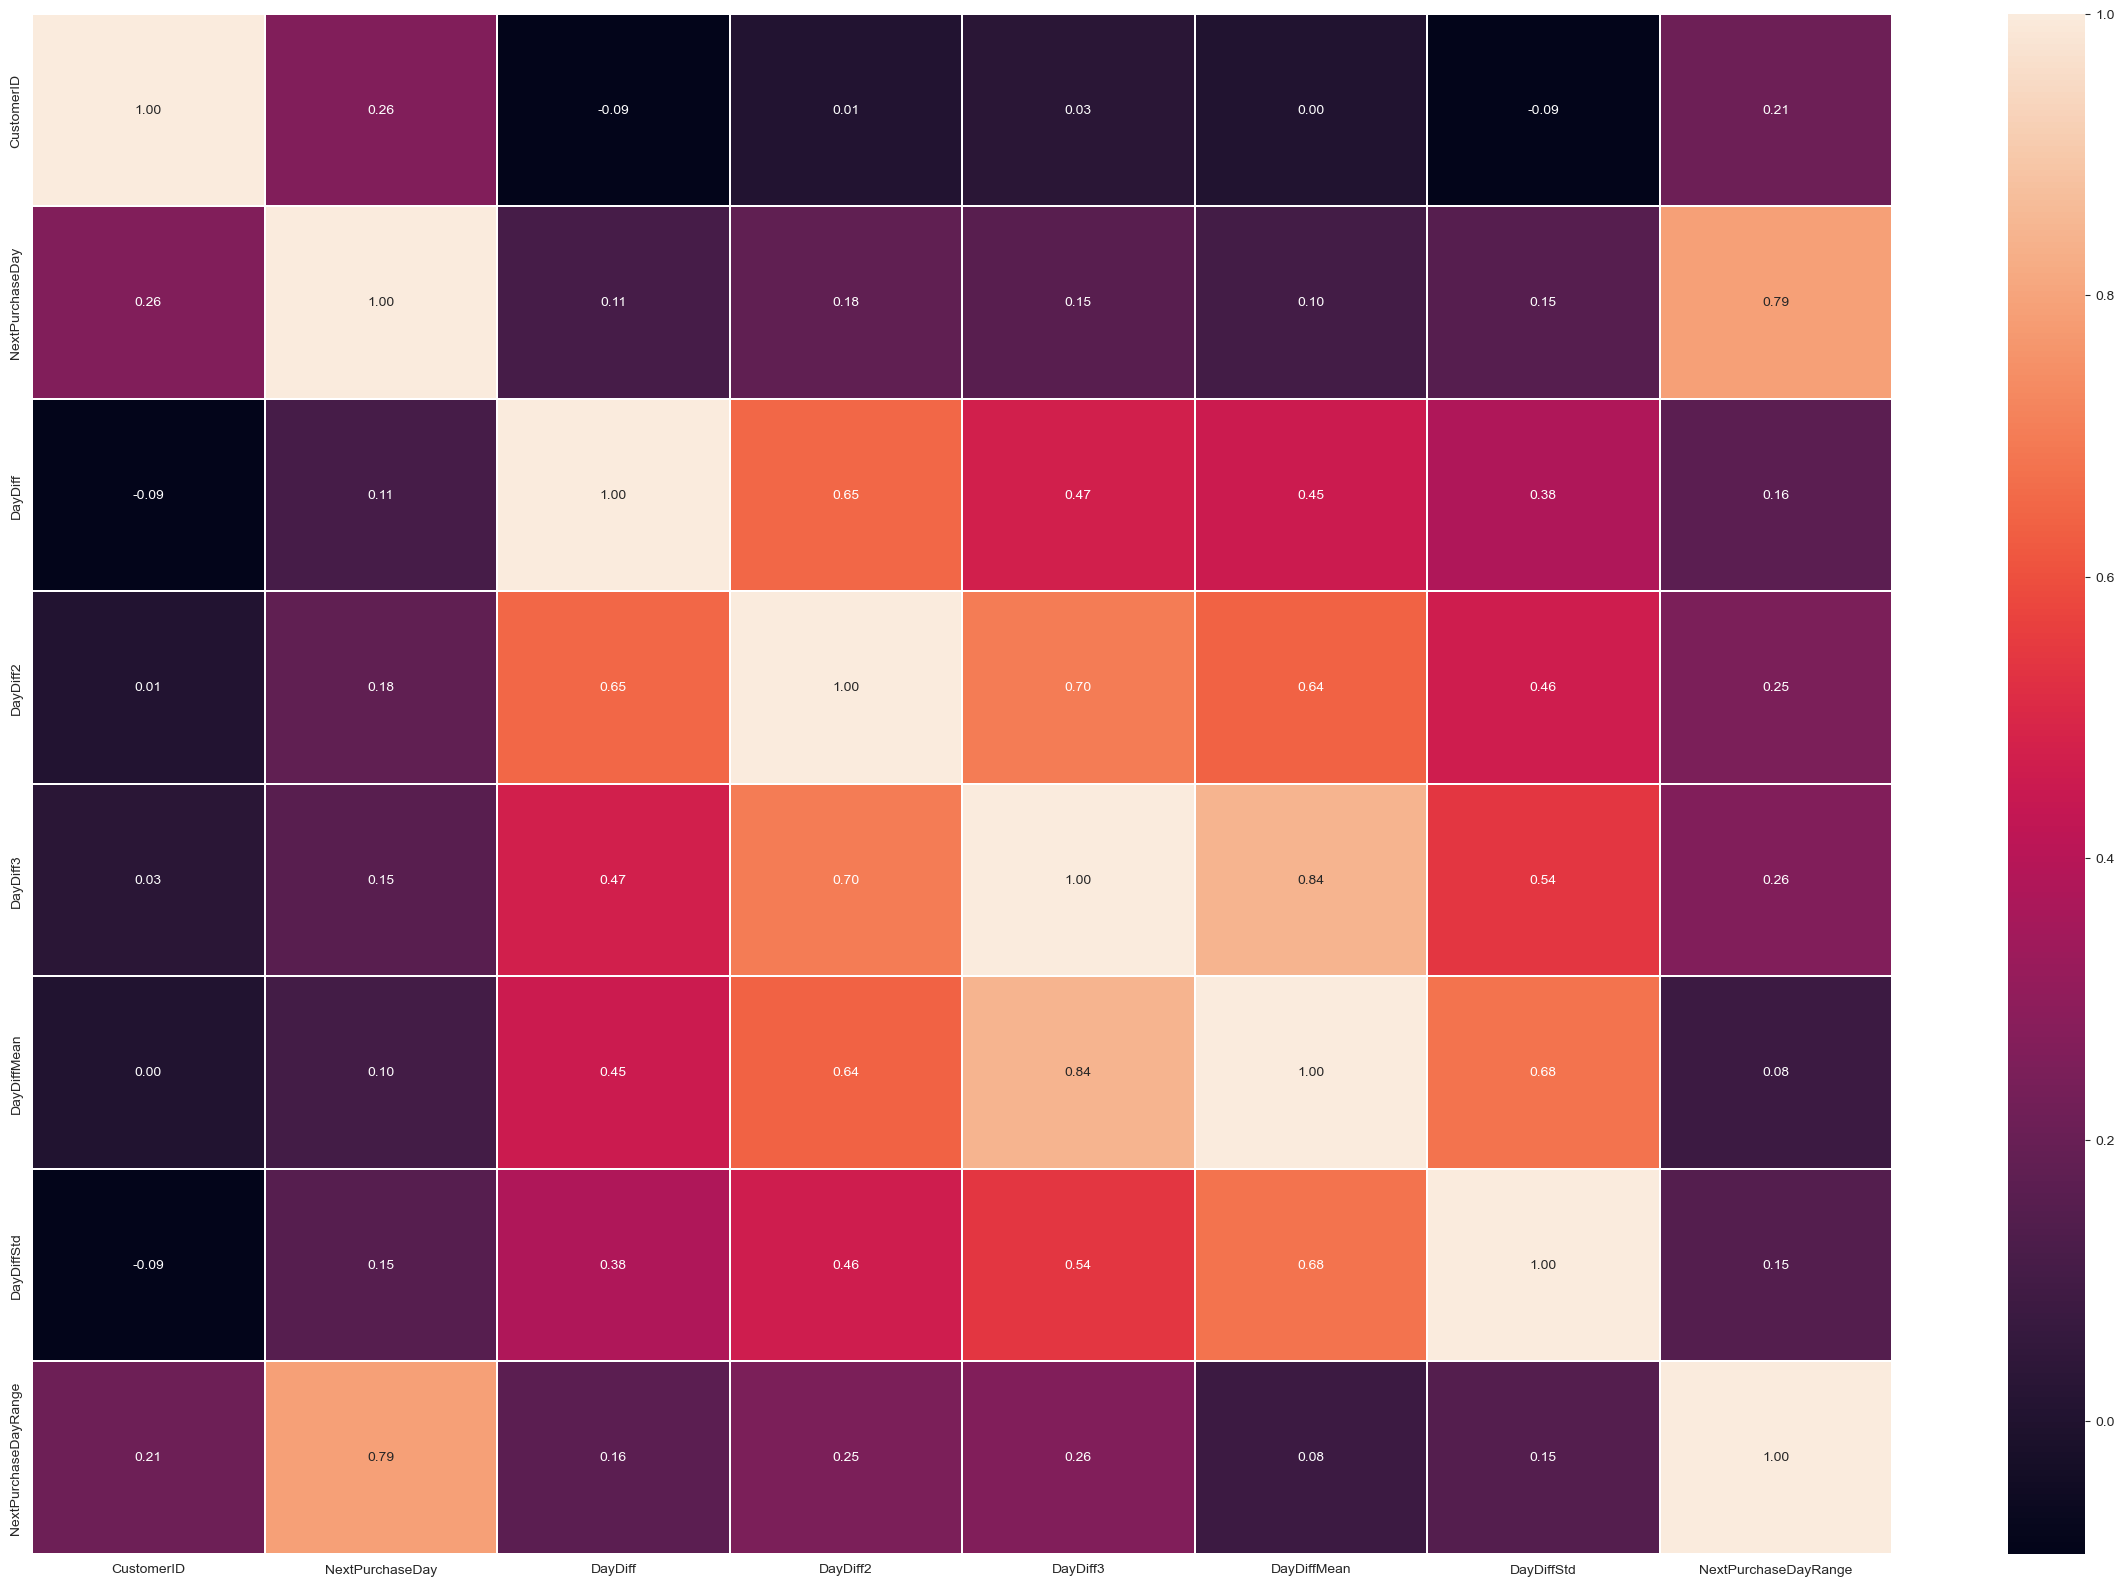

In [304]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [307]:
tx_class.columns

Index(['CustomerID', 'NextPurchaseDay', 'DayDiff', 'DayDiff2', 'DayDiff3',
       'DayDiffMean', 'DayDiffStd', 'NextPurchaseDayRange'],
      dtype='object')

In [308]:
#splitting 
tx_class = tx_class.drop('NextPurchaseDay',axis=1)
X = tx_class.drop(columns = ['NextPurchaseDayRange'])
y = tx_class["NextPurchaseDayRange"]

In [309]:
y

0     4.0
1     1.0
2     1.0
3     4.0
4     2.0
5     4.0
6     3.0
7     2.0
8     1.0
9     4.0
10    3.0
11    1.0
12    4.0
13    4.0
14    1.0
15    2.0
16    4.0
17    1.0
18    4.0
19    4.0
20    2.0
21    2.0
22    2.0
23    2.0
24    4.0
25    4.0
26    4.0
27    4.0
28    3.0
29    4.0
30    1.0
31    2.0
32    4.0
33    2.0
34    4.0
35    4.0
36    4.0
37    3.0
38    4.0
39    3.0
40    4.0
41    4.0
42    4.0
43    4.0
44    4.0
45    4.0
46    1.0
47    4.0
48    2.0
49    4.0
50    4.0
51    2.0
52    3.0
53    3.0
54    3.0
Name: NextPurchaseDayRange, dtype: float64

In [310]:
#Encoder for y variable
enc =LabelEncoder()
y = enc.fit_transform(y)

In [311]:
X

,CustomerID,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,15100,16.0,72.0,153.0,39.250000,35.621857
1,15311,8.0,19.0,35.0,14.100000,7.809538
2,16029,42.0,48.0,77.0,25.666667,18.230012
3,17511,4.0,5.0,50.0,21.500000,31.778924
4,13408,18.0,59.0,67.0,23.500000,14.011900
5,13767,26.0,56.0,76.0,28.000000,6.733003
6,13694,37.0,49.0,65.0,16.500000,15.066519
7,14911,1.0,22.0,28.0,12.000000,14.142136
8,17841,12.0,37.0,53.0,20.000000,14.947527
9,13093,5.0,29.0,76.0,25.333333,21.031722


In [312]:
y

array([3, 0, 0, 3, 1, 3, 2, 1, 0, 3, 2, 0, 3, 3, 0, 1, 3, 0, 3, 3, 1, 1,
       1, 1, 3, 3, 3, 3, 2, 3, 0, 1, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3,
       3, 3, 0, 3, 1, 3, 3, 1, 2, 2, 2], dtype=int64)

In [313]:
# Checking balancing of data
tx_class.NextPurchaseDayRange.value_counts()

NextPurchaseDayRange
4.0    28
2.0    11
1.0     8
3.0     8
Name: count, dtype: int64

In [314]:
X.shape

(55, 6)

In [315]:
y.shape

(55,)

# 7. Perform cohort analysis by defining below cohorts
####  Customers who started in each month and understand their behaviour
####  Which Month cohort has maximum retention?

In [318]:
def get_month(x) : return dt.datetime(x.year,x.month,1)
df_fin['InvoiceMonth'] = df_fin['Transaction_Date'].apply(get_month)
grouping = df_fin.groupby('CustomerID')['InvoiceMonth']
df_fin['CohortMonth'] = grouping.transform('min')
df_fin.tail()

,CustomerID,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Tenure_Months,GST,Discount_pct,Product_Category_Android,Product_Category_Apparel,...,Recency,Frequency,MonetaryValue,Deciles,r_seg,f_seg,m_seg,fm_seg,InvoiceMonth,CohortMonth
52519,12990,46843,1,355.74,6.5,47,0.05,30,False,False,...,18,3,486.20,0,Active,1,1,Standard,2019-12-01,2019-12-01
52520,12990,46843,2,49.95,6.5,47,0.05,30,False,False,...,18,3,486.20,0,Active,1,1,Standard,2019-12-01,2019-12-01
52521,16333,47144,1,355.74,6.5,41,0.05,30,False,False,...,16,2,558.59,0,Active,1,1,Standard,2019-12-01,2019-12-01
52522,16333,47144,5,49.95,6.5,41,0.05,30,False,False,...,16,2,558.59,0,Active,1,1,Standard,2019-12-01,2019-12-01
52523,18017,46708,1,19.56,6.5,37,0.18,30,False,False,...,19,1,-3.76,0,Active,1,1,Standard,2019-12-01,2019-12-01


In [319]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_month_int(df_fin,'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df_fin,'CohortMonth')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 

df_fin['CohortIndex'] = year_diff * 12 + month_diff + 1 

In [320]:
#Count monthly active customers from each cohort
grouping = df_fin.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2019-01-01,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0
2019-02-01,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,NaN
2019-03-01,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,NaN,NaN
2019-04-01,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,NaN,NaN,NaN
2019-05-01,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,NaN,NaN,NaN,NaN
2019-06-01,137.0,20.0,22.0,12.0,11.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN
2019-07-01,93.0,12.0,4.0,5.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,136.0,14.0,16.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,78.0,6.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Retention Table

In [321]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2019-01-01,100.0,6.0,11.2,15.8,10.7,20.5,16.3,21.9,10.7,13.0,9.3,15.8
2019-02-01,100.0,7.3,9.4,16.7,17.7,22.9,19.8,15.6,12.5,11.5,16.7,NaN
2019-03-01,100.0,10.2,19.8,14.1,18.1,18.6,12.4,12.4,8.5,10.7,NaN,NaN
2019-04-01,100.0,8.6,14.7,14.7,11.0,9.2,6.1,9.8,7.4,NaN,NaN,NaN
2019-05-01,100.0,10.7,8.0,11.6,8.9,11.6,12.5,7.1,NaN,NaN,NaN,NaN
2019-06-01,100.0,14.6,16.1,8.8,8.0,10.2,8.0,NaN,NaN,NaN,NaN,NaN
2019-07-01,100.0,12.9,4.3,5.4,10.8,8.6,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,100.0,10.3,11.8,8.1,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,100.0,7.7,3.8,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


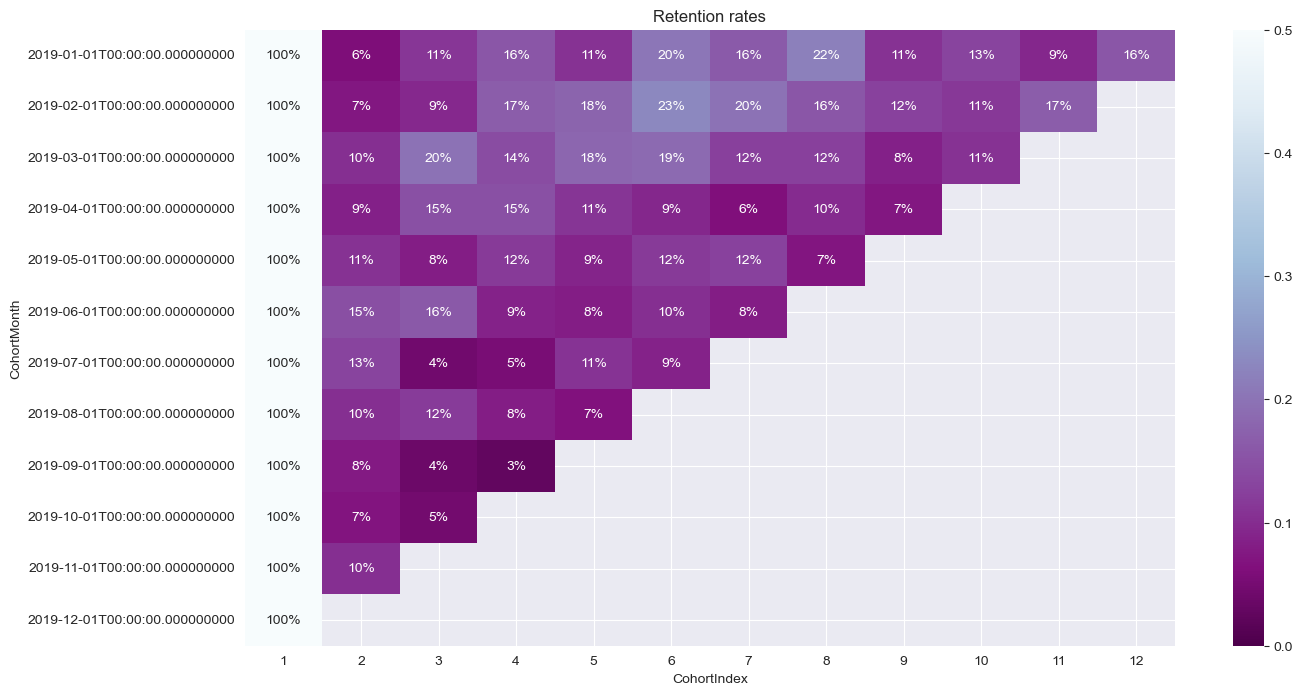

In [322]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()